# Shortlisting Players for a Champions League Club

In this notebook I will attempt to shortlist players from the provided data for a Champions League club. In particular, the team is looking for a **Defensive Midfielder**, a **Centre Back** and a **Winger**.

In [539]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patheffects, lines
from matplotlib.patches import Circle,FancyArrowPatch
from textwrap import fill,wrap
from highlight_text.htext import htext
from datetime import datetime, date
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import preprocessing

plt.style.use('football')

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 3)

In [3]:
df = pd.read_csv("data_analyst_task_data.csv")

In [4]:
print("There are",len(df['team_id'].unique()),"teams in the data set.")

There are 20 teams in the data set.


In [5]:
print("There are",len(df['player_id'].unique()),"unique players in the data set.")

There are 603 unique players in the data set.


In [6]:
df.head()

,player_id,player_birth_date,game_id,position,touches,team_id,mins_played,game_started,ball_recovery,blocked_pass,total_tackle,won_tackle,aerial_won,aerial_lost,interception,fouls,error_lead_to_goal,error_lead_to_shot,total_clearance,final_third_entries,pen_area_entries,poss_lost_all,total_cross,total_pass,total_long_balls,total_through_ball,accurate_pass,accurate_through_ball,accurate_cross,total_att_assist,won_contest,total_contest,touches_in_opp_box,total_scoring_att,goals,expected_goals,ontarget_scoring_att,saves,clean_sheet,saved_ibox,saved_obox,goals_conceded
0,56448,1991-02-16,869636,Midfielder,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0
1,140264,1990-05-24,869728,Midfielder,64,953,90,1,8,2,2,2,2,1,3,3,0,0,1,7,0,7,0,51,13,0,44,0,0,0,0,0,0,2,0,0.051,0,0,0,0,0,1
2,126290,1991-07-18,869481,Midfielder,34,953,90,1,1,2,2,0,2,2,3,1,0,0,1,2,4,14,2,14,2,0,8,0,0,0,1,1,4,1,0,0.058,1,0,0,0,0,1
3,58906,1986-11-21,869573,Midfielder,15,616,21,0,1,0,0,0,0,1,1,2,0,0,1,1,0,1,0,9,2,0,9,0,0,0,0,1,0,0,0,0.000,0,0,0,0,0,0
4,39817,1984-06-12,869642,Midfielder,96,449,90,1,11,2,2,1,0,1,3,1,0,0,0,20,2,8,0,87,2,0,80,0,0,1,0,1,0,0,0,0.000,0,0,0,0,0,2


Total minutes played by each player.

In [7]:
df_players = pd.DataFrame(df.groupby('player_id')['mins_played'].sum())

Then get 90s played.

In [8]:
df_players['90s'] = df_players['mins_played']/90

Age.

In [9]:
def calculate_age(birth_date):
    today = date.today()
    age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    return age

In [10]:
birth_dates = []
for pid in df_players.index:
    player = df[df['player_id'] == pid]
    birth_date = datetime.strptime(player['player_birth_date'].iloc[0], "%Y-%m-%d").date()
    birth_dates.append(calculate_age(birth_date))

In [11]:
df_players['age'] = birth_dates

Games played and number of starts.

In [12]:
df_players['gp'] = df.groupby('player_id').size()
df_players['games_started'] = df.groupby('player_id')['game_started'].sum()

Position of each player. First check that the position of a player does not change.

In [13]:
for pid in df['player_id'].unique():
    if len(df[df['player_id'] == 140264]['position'].value_counts()) < 1:
        print('More than one position')

We see that every player has a single position. Now find position of every player.

In [14]:
df_players['position'] = np.ravel(df.groupby('player_id')['position'].unique().to_list())

In [15]:
df_players.head()

,mins_played,90s,age,gp,games_started,position
player_id,,,,,,
7088,2051,22.789,38,32,22,Defender
7261,540,6.000,39,16,6,Defender
10316,1675,18.611,39,31,19,Midfielder
10343,864,9.600,36,30,10,Midfielder
11129,3240,36.000,30,36,36,Defender


### Age distribution

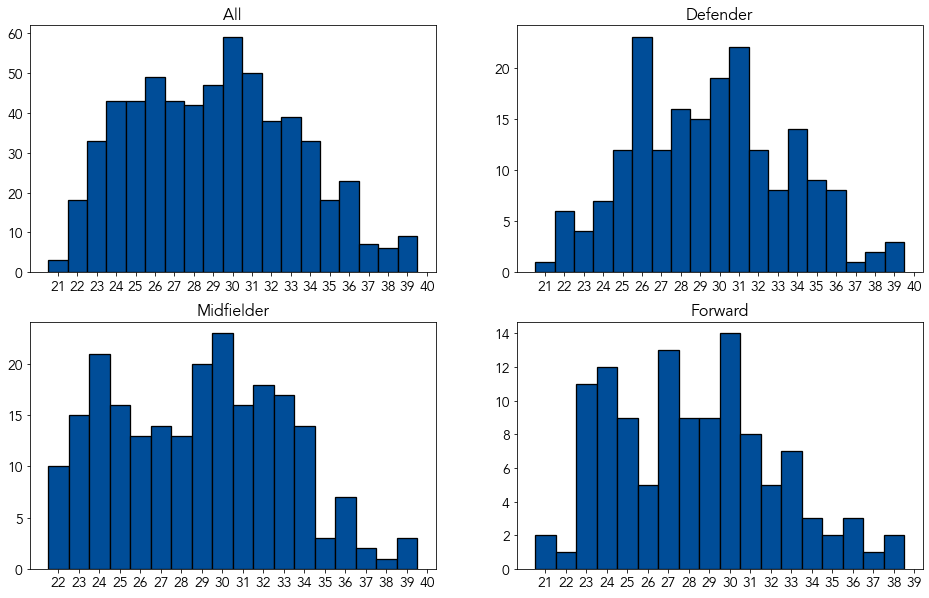

In [17]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(16,10))

for i,pos in enumerate(['All','Defender','Midfielder','Forward']):
    if pos == 'All':
        age_vals = df_players['age'].to_numpy()
    else:
        age_vals = df_players[df_players['position'] == pos]['age'].to_numpy()
    bins = np.arange(age_vals.min(),age_vals.max()+1,1)
    axs[i//2,i%2].hist(age_vals,bins=bins,align='left',label=pos)
    axs[i//2,i%2].set_title(pos)
    axs[i//2,i%2].set_xticks(bins)

plt.show()

There are very few defenders 24 years and younger. Midfielders have the largest population of under 25s.

## Team Stats

I thought about calculating the points each team ended the season with by using *game_id*, *team_id* and *goals*. However, *goals* does not include own goals so the results won't be completely accurate. Neverthelss, they could serve as a decent estimator of team performance over the season.

In [18]:
df_games = df.groupby(['game_id','team_id'])['goals'].sum().reset_index()

In [19]:
team_points = {}
gp = {}
wins = {}
draws = {}
loss = {}
for gid in df_games['game_id'].unique():
    df_game = df_games[df_games['game_id'] == gid].copy()
    gp[df_game.iloc[0]['team_id']] = gp.get(df_game.iloc[0]['team_id'],0) + 1
    gp[df_game.iloc[1]['team_id']] = gp.get(df_game.iloc[1]['team_id'],0) + 1
    if df_game.iloc[0]['goals'] > df_game.iloc[1]['goals']:
        t1 = df_game.iloc[0]['team_id']
        t2 = df_game.iloc[1]['team_id']
        team_points[t1] = team_points.get(t1, 0) + 3
        team_points[t2] = team_points.get(t2, 0) + 0
        wins[t1] = wins.get(t1,0) + 1
        loss[t2] = loss.get(t2,0) + 1
    elif df_game.iloc[0]['goals'] < df_game.iloc[1]['goals']:
        t1 = df_game.iloc[0]['team_id']
        t2 = df_game.iloc[1]['team_id']
        team_points[t1] = team_points.get(t1, 0) + 0
        team_points[t2] = team_points.get(t2, 0) + 3
        wins[t2] = wins.get(t2,0) + 1
        loss[t1] = loss.get(t1,0) + 1
    elif df_game.iloc[0]['goals'] == df_game.iloc[1]['goals']:
        t1 = df_game.iloc[0]['team_id']
        t2 = df_game.iloc[1]['team_id']
        team_points[t1] = team_points.get(t1, 0) + 1
        team_points[t2] = team_points.get(t2, 0) + 1
        draws[t1] = draws.get(t1,0) + 1
        draws[t2] = draws.get(t2,0) + 1
    else:
        print("Error")

In [20]:
df_points = pd.Series(team_points).sort_values(ascending=False)

### Approximate Possession

Can approximate possession as the share of passes a team has in a game. Using the *total_pass* and *total_cross* variables the only unaccounted for passes are throw-ins and keeper throws, so this should be reasonable approximation.

In [21]:
df_passes = df.groupby(['game_id','team_id'])[['total_pass','total_cross']].sum().sum(axis=1).reset_index()
df_passes.rename(columns={0:'passes'},inplace=True)

In [22]:
df_passes.head()

,game_id,team_id,passes
0,869457,186,551
1,869457,188,440
2,869458,182,419
3,869458,450,337
4,869459,177,203


In [23]:
poss = []
for gid in df_passes['game_id'].unique():
    df_game = df_passes[df_passes['game_id'] == gid]
    poss.append(df_game.iloc[0]['passes'] / df_game['passes'].sum())
    poss.append(df_game.iloc[1]['passes'] / df_game['passes'].sum())

In [24]:
df_passes['poss'] = poss

In [25]:
df_passes.head()

,game_id,team_id,passes,poss
0,869457,186,551,0.556
1,869457,188,440,0.444
2,869458,182,419,0.554
3,869458,450,337,0.446
4,869459,177,203,0.251


## Possession Adjusting Defensive Attributes

When looking at defensive metrics it is becomes harder to definitively say what is good - it is more stylistic. One big issue is teams that have less possession will have more defending to do and therefore their players will tend to perform more defensive actions.

One way to get around this is to adjust the defensive statistics by the possession the team has. Then players should be able to be compared defensively on a more equal footing. 

From there it is still not a case of "*more tackles means a better defender*". It is more of a case of style, as mentioned. A defender with higher attempted tackle total likes to engage more - whether this is personal or team instructions. Tackle success % is a measure to show how successful they are.

Variables that need to be possession adjusted are *total_tackle*, *won_tackle*, *aerial_won*, *aerial_lost*, *interception*, *total_clearance*. However, I will likely use *won_tackle* to calculate *tackle %* and *aerial_lost* to calculate *aerial %* so do that before possession adjusting.

In [26]:
df_adj = pd.merge(df,df_passes,on=['game_id','team_id'])

In [27]:
df_adj[df_adj['game_id'] == 869705].head()

,player_id,player_birth_date,game_id,position,touches,team_id,mins_played,game_started,ball_recovery,blocked_pass,total_tackle,won_tackle,aerial_won,aerial_lost,interception,fouls,error_lead_to_goal,error_lead_to_shot,total_clearance,final_third_entries,pen_area_entries,poss_lost_all,total_cross,total_pass,total_long_balls,total_through_ball,accurate_pass,accurate_through_ball,accurate_cross,total_att_assist,won_contest,total_contest,touches_in_opp_box,total_scoring_att,goals,expected_goals,ontarget_scoring_att,saves,clean_sheet,saved_ibox,saved_obox,goals_conceded,passes,poss
754,88554,1992-11-22,869705,Midfielder,0,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0,407,0.448
755,59325,1991-06-21,869705,Midfielder,31,180,54,1,0,3,0,0,2,3,0,0,0,0,0,4,2,14,0,21,1,0,13,0,0,0,0,3,1,1,0,0.062,0,0,0,0,0,0,407,0.448
756,20062,1985-06-07,869705,Midfielder,7,180,14,0,1,1,0,0,0,2,0,1,0,0,0,2,0,3,0,6,1,0,3,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0,407,0.448
757,61960,1988-05-27,869705,Midfielder,51,180,90,1,6,3,2,2,5,3,0,0,0,0,0,9,1,9,0,38,3,0,31,0,0,1,1,1,1,2,0,0.103,0,0,0,0,0,1,407,0.448
758,92724,1988-08-01,869705,Midfielder,68,180,90,1,13,0,4,3,1,1,0,0,0,0,3,4,8,13,7,46,4,0,42,0,0,0,1,2,1,1,0,0.028,0,0,0,0,0,1,407,0.448


In [28]:
# Sigmoid adjustment (behaves better at extremes)
def poss_adj(row,stat):
    return (row[stat]*2) / (1+np.exp(-0.1 * ((row['poss']*100) - 50)))

In [29]:
# Simple adjustment
def poss_adj2(row):
    return row['total_tackle'] * (0.5/(1-row['poss']))

In [30]:
# Sigmoid adjustment (behaves better at extremes)
def poss_adj(row):
    total_tackle_adj = (row['total_tackle']*2) / (1+np.exp(-0.1 * ((row['poss']*100) - 50)))
    aerial_won_adj = (row['aerial_won']*2) / (1+np.exp(-0.1 * ((row['poss']*100) - 50)))
    interception_adj = (row['interception']*2) / (1+np.exp(-0.1 * ((row['poss']*100) - 50)))
    total_clearance_adj = (row['total_clearance']*2) / (1+np.exp(-0.1 * ((row['poss']*100) - 50)))
    return total_tackle_adj, aerial_won_adj, interception_adj, total_clearance_adj

In [31]:
df_adj['total_tackle_adj'], df_adj['aerial_won_adj'], df_adj['interception_adj'], df_adj['total_clearance_adj'] = zip(*df_adj.apply(poss_adj,axis=1))

In [33]:
df_adj.head()

,player_id,player_birth_date,game_id,position,touches,team_id,mins_played,game_started,ball_recovery,blocked_pass,total_tackle,won_tackle,aerial_won,aerial_lost,interception,fouls,error_lead_to_goal,error_lead_to_shot,total_clearance,final_third_entries,pen_area_entries,poss_lost_all,total_cross,total_pass,total_long_balls,total_through_ball,accurate_pass,accurate_through_ball,accurate_cross,total_att_assist,won_contest,total_contest,touches_in_opp_box,total_scoring_att,goals,expected_goals,ontarget_scoring_att,saves,clean_sheet,saved_ibox,saved_obox,goals_conceded,passes,poss,total_tackle_adj,aerial_won_adj,interception_adj,total_clearance_adj
0,56448,1991-02-16,869636,Midfielder,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,522,0.601,0.000,0.000,0.000,0.000
1,84086,1990-03-08,869636,Midfielder,38,188,34,0,4,1,4,3,1,1,1,1,0,0,1,3,1,4,0,29,6,0,25,0,0,0,1,1,0,0,0,0.0,0,0,0,0,0,0,522,0.601,5.870,1.468,1.468,1.468
2,17512,1983-08-29,869636,Midfielder,64,188,90,1,7,4,2,1,0,1,1,0,0,0,0,7,6,17,4,49,5,0,40,0,0,1,0,0,0,0,0,0.0,0,0,1,0,0,0,522,0.601,2.935,0.000,1.468,0.000
3,176163,1996-11-20,869636,Midfielder,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,522,0.601,0.000,0.000,0.000,0.000
4,46998,1987-07-02,869636,Midfielder,67,188,90,1,7,2,1,1,2,0,1,1,0,0,2,3,10,15,9,45,2,0,38,0,4,3,2,2,1,0,0,0.0,0,0,1,0,0,0,522,0.601,1.468,2.935,1.468,2.935


## Winger

In [37]:
wing_attr = ['touches','final_third_entries','pen_area_entries','poss_lost_all','total_cross','total_pass','total_long_balls',
 'total_through_ball','accurate_pass','accurate_through_ball','accurate_cross','total_att_assist','won_contest',
'total_contest','touches_in_opp_box','total_scoring_att','goals','expected_goals','ontarget_scoring_att']

In [38]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#004d98', '#edbb00', '#a50044', 'xkcd:green', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


Think about whether every attribute is better if it is higher. `poss_lost_all` is the only one, that I can see, that is clearly worse when it has a higher value. Therefore, we should flip the percentile rank by doing 100 minus the current percentile rank. Now a higher value is a lower rank.

In [39]:
def get_df_pos(df,attr,nineties=10,age_range=None,exclude_pos=['Goalkeeper']):
    """ Function to get two dataframes of players with the per 90 and per 90 percentiles of the specified relevent 
    attributes. """
    all_attr = [i for i in df.columns if i not in ['player_id', 'player_birth_date', 'game_id', 'position','team_id', 'mins_played','game_started','passes','poss']]
    
    # Create a player dataframe with personal stats
    df_players = pd.DataFrame(df.groupby('player_id')['mins_played'].sum())
    df_players['90s'] = df_players['mins_played']/90
    birth_dates = []
    for pid in df_players.index:
        player = df[df['player_id'] == pid]
        birth_date = datetime.strptime(player['player_birth_date'].iloc[0], "%Y-%m-%d").date()
        birth_dates.append(calculate_age(birth_date))
    df_players['age'] = birth_dates
    df_players['gp'] = df.groupby('player_id').size()
    df_players['games_started'] = df.groupby('player_id')['game_started'].sum()
    df_players['position'] = np.ravel(df.groupby('player_id')['position'].unique().to_list())
    
    # Create dataframe of player stat totals
    df_total = pd.concat([df_players, df.groupby('player_id')[all_attr].sum()], axis=1)
    df_total['xG/shot'] = df_total['expected_goals'] / df_total['total_scoring_att']
    df_total['pass%'] = df_total['accurate_pass'] / df_total['total_pass']
    df_total['cross%'] = df_total['accurate_cross'] / df_total['total_cross']
    df_total['contest%'] = df_total['won_contest'] / df_total['total_contest']
    df_total['tackle%'] = df_total['won_tackle'] / df_total['total_tackle']
    df_total['aerial%'] = df_total['aerial_won'] / (df_total['aerial_won'] + df_total['aerial_lost'])
    df_total['long_ball_to_pass%'] = df_total['total_long_balls'] / df_total['total_pass']
    df_total.fillna(0,inplace=True)
    # Player stat p90 values
    df_total_p90 = pd.concat([df_players,df_total.groupby('player_id')[all_attr].sum().div(df_players['90s'], axis=0).fillna(0)], axis=1)
    df_total_p90['xG/shot'] = df_total['xG/shot']
    df_total_p90['pass%'] = df_total['pass%']
    df_total_p90['cross%'] = df_total['cross%']
    df_total_p90['contest%'] = df_total['contest%']
    df_total_p90['tackle%'] = df_total['tackle%']
    df_total_p90['aerial%'] = df_total['aerial%']
    df_total_p90['long_ball_to_pass%'] = df_total['long_ball_to_pass%']
    
    # Create dataframe focusing on the specified important stats
    df_pos = df_total[['mins_played', '90s', 'age', 'gp', 'games_started', 'position']+attr]
    df_pos_p90 = df_total_p90[['mins_played', '90s', 'age', 'gp', 'games_started', 'position']+attr]
    
    # Filter by 90s played
    df_pos_p90 = df_pos_p90[df_pos_p90['90s'] >= nineties].copy()
    # Excluding positions
    if exclude_pos:
        df_pos_p90 = df_pos_p90[~df_pos_p90['position'].isin(exclude_pos)].copy()
    # Age range
    if age_range:
        df_pos_p90 = df_pos_p90[(df_pos_p90['age'] >= age_range[0])&(df_pos_p90['age'] <= age_range[1])].copy()
        
    # Calculate percentiles
    df_pos_p90_per = df_pos_p90.copy()
    for a in attr:
        df_pos_p90_per[a] = df_pos_p90[a].apply(lambda x: stats.percentileofscore(df_pos_p90[a],x))
    # Flip attributes where lower is better such that higher percentile again means better
    if 'poss_lost_all' in attr:
        df_pos_p90_per['poss_lost_all'] = 100 - df_pos_p90_per['poss_lost_all']
    if 'fouls' in attr:
        df_pos_p90_per['fouls'] = 100 - df_pos_p90_per['fouls']
    if 'error_lead_to_goal' in attr:
        df_pos_p90_per['error_lead_to_goal'] = 100 - df_pos_p90_per['error_lead_to_goal']
    if 'error_lead_to_shot' in attr:
        df_pos_p90_per['error_lead_to_shot'] = 100 - df_pos_p90_per['error_lead_to_shot']
    
    return df_pos_p90, df_pos_p90_per

In [40]:
wing_shot_attr = ['expected_goals','total_scoring_att','xG/shot']
wing_pass_attr = ['total_att_assist','total_pass','pass%']
wing_cross_attr = ['total_cross','cross%']
wing_drib_attr = ['total_contest','contest%']

In [41]:
wing_attr_key = ['expected_goals','total_scoring_att','xG/shot','total_att_assist','pass%',
                 'total_cross','touches_in_opp_box','won_contest','poss_lost_all']

In [42]:
wing_attr_key2 = ['expected_goals','total_scoring_att','xG/shot','total_att_assist','total_pass','pass%',
                  'total_cross','cross%','touches_in_opp_box','total_contest','contest%','poss_lost_all']

In [43]:
df_pos_p90, df_pos_p90_per = get_df_pos(df,wing_attr_key2,nineties=20,exclude_pos=['Goalkeeper','Defender'])

In [507]:
def plot_bars(df_players,df_pos_p90,df_pos_p90_per,attrs,pid,bar_cmap='RdYlGn',annotations=True,ax=None,
              attr_labels=['xG','Shots','xG/Shot','Key Passes','Passing %','Crosses','Touches in Box','Successful Dribbles','Poss. Losses'],
             alpha=0.8,fs=12):
    
    df_pos_p90 = df_pos_p90[attrs]
    df_pos_p90_per = df_pos_p90_per[attrs]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    
    cmap = plt.get_cmap(bar_cmap)
    norm = mpl.colors.Normalize(vmin=0, vmax=100)

    y_range = np.arange(len(attrs),0,-1)

    ax.barh(np.arange(len(attrs),0,-1),df_pos_p90_per.loc[pid].values - 50,left=50,color=cmap(norm(df_pos_p90_per.loc[pid].values)),alpha=alpha)
    ax.axvline(50,c='k',lw=1,ls='--')
    for i,attr in enumerate(attrs):
        if df_pos_p90_per.loc[pid,attr] >= 75:
            ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=1,foreground="w")])
        elif df_pos_p90_per.loc[pid,attr] >= 50:
            ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',color='k',path_effects=[patheffects.withStroke(linewidth=1,foreground="w")])
        elif df_pos_p90_per.loc[pid,attr] <= 25:
            ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]+2,y_range[i]),annotation_clip=False,ha='left',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=1,foreground="w")])
        else:
            ax.annotate('{:.2f}'.format(df_pos_p90.loc[pid,attr]),(df_pos_p90_per.loc[pid,attr]-2,y_range[i]),annotation_clip=False,ha='right',va='center',size=fs,weight='medium',path_effects=[patheffects.withStroke(linewidth=1,foreground="w")])

    #attr_labels = ['xG','Shots','xG/Shot','Key Passes','Passing %','Crosses','Touches in Box','Successful Dribbles','Poss. Losses']
    ax.set_xlim(0,100)
    ax.set_yticks(np.arange(len(attrs),0,-1))
    ax.set_yticklabels(attr_labels,size=fs,weight='medium')
    ax.set_xticks(np.arange(0,125,25))
    ax.tick_params(bottom=False,left=False,labelbottom=False)
    for i in ['top','bottom']:
        ax.spines[i].set_visible(False)

    ax.grid(axis='x',ls='--',alpha=1)
    ax.text(0.5,1,'Median',ha='center',va='bottom',transform=ax.transAxes,size=fs)
    
    if annotations:
        ax.text(0,1.22,"Player ID: {}".format(pid),transform=ax.transAxes,fontsize=fs,fontweight='bold',ha='left',va='bottom')
        ax.text(0,1.15,"{}".format(df_players.loc[pid,'position']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='left',va='bottom')
        ax.text(0,1.1,"Values per 90 minutes played",transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='left',va='bottom')

        ax.text(1.,1.22,"Age: {}".format(df_players.loc[pid,'age']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='right',va='bottom')
        ax.text(1.,1.15,"90s Played: {:.1f}".format(df_players.loc[pid,'90s']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='right',va='bottom')
        ax.text(1.,1.1,"{} Games Played, {} Starts".format(df_players.loc[pid,'gp'],df_players.loc[pid,'games_started']),transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='right',va='bottom')

        #line = lines.Line2D([-10,110], [10.5,10.5], lw=1., color='k', clip_on=False,transform=ax.transAxes)
        line = lines.Line2D([-0.1,1.1], [1.05,1.05], lw=1., color='k', clip_on=False,transform=ax.transAxes)
        ax.add_line(line)

        ax.text(0.5,-0.1,"Compared to all players who have played at least 10 90s.",transform=ax.transAxes,fontsize=fs,fontweight='normal',ha='center',va='bottom')
    
    return ax

In [45]:
attr_labels = ['xG','Shots','xG/Shot','Key Passes','Passes','Passing %','Crosses','Cross %','Touches in Box','Dribbles','Dribble %','Poss. Losses']
plot_bars(df_players,df_pos_p90,df_pos_p90_per,wing_attr_key2,61278,attr_labels=attr_labels,annotations=False)
plt.close()

#### Box plots

In [46]:
# Select quick top 10 from summed percentiles in key attr
top10 = df_pos_p90_per[wing_attr_key2].sum(axis=1).sort_values(ascending=False).iloc[:10].index
df_top10 = df_pos_p90[wing_attr_key2].loc[top10]
df_top10_per = df_pos_p90_per[wing_attr_key2].loc[top10]

In [49]:
fig,ax = plt.subplots(figsize=(10,8))

players = df_top10.index.to_list()

data = []
for i,p in enumerate(players):
    vals = df[df['player_id'] == p]['expected_goals'].to_list()
    data.append(vals)
    ax.scatter(vals,[i+1]*len(vals),s=10,c='k',zorder=1)
    #np.array(data, dtype=object)
    
bplot = ax.boxplot(data,vert=False,labels=players,patch_artist=True,showmeans=True,meanline=True,medianprops={'color':'k'},zorder=1)
#ax.scatter(data,[i+1]*len(data))

for patch in bplot['boxes']:
    patch.set_facecolor('0.8')
    #patch.set_alpha(0.8)

plt.close()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Player Style

To determine a player's playing style I will use Principal Component Analysis (PCA) in combination with different groups of attributes that I believe correspond to different styles. Looking at the features of the data, we could separte into *Shooting*, *Passing*, *Dribbling* and *Crossing* preferences. Since I am aiming to determine style here I will focus on attributes that specify quantity rather than quality.

In [50]:
shot_attr = ['total_scoring_att']#,'expected_goals']
pass_attr = ['total_pass']#,'total_through_ball','total_att_assist']
drib_attr = ['total_contest']
cross_attr = ['total_cross']
creat_attr = ['total_att_assist','total_through_ball','pen_area_entries']
style_attr = shot_attr + pass_attr + drib_attr + cross_attr + creat_attr

With the attributes of each group specified, the next step is to perform PCA on each group separately to combine the features of each group into a single feature that describes how important that group is to a player's style.

In [51]:
def change_range(value,old_range,new_range):
    return ((value - old_range[0])/(old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]

Get the data. I will use all midfielders and forwards who have played at least 10 90s.

In [52]:
df_pca_p90,df_pca_p90_per = get_df_pos(df,style_attr,nineties=10,exclude_pos=['Goalkeeper','Defender'])

Perform PCA on each group. I will use the percentile ranks as the value for each player in each attribute rather than the raw value.

In [53]:
def get_df_style(df,attrs=[shot_attr,pass_attr,drib_attr,cross_attr,creat_attr],
                 styles=['shot','pass','drib','cross','creat'],nineties=10,exclude_pos=['Goalkeeper','Defender'],
                team=False,special_pos=False):
    
    if team is False:
        # Flatten attrs list for get_df_pos
        style_attr = [j for i in attrs for j in i]
        # Get the DataFrames for the given attributes, nineties and positions
        df_pos_p90,df_pos_p90_per = get_df_pos(df,style_attr,nineties=nineties,exclude_pos=exclude_pos)
        
        if special_pos == 'Centre Back':
            df_pos_p90 = pd.merge(df_pos_p90,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
            df_pos_p90_per = pd.merge(df_pos_p90_per,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
            df_pos_p90 = df_pos_p90[df_pos_p90['fb'] <= 0].copy()
            df_pos_p90_per = df_pos_p90_per[df_pos_p90_per['fb'] <= 0].copy()
        
        # Create the style DataFrame
        df_style = pd.DataFrame(index=df_pos_p90_per.index)
        for i,group in enumerate(attrs):
            if len(group) > 1:
                X = preprocessing.scale(df_pos_p90_per[group])
                pca = PCA(n_components=1)
                df_style[styles[i]] = pca.fit_transform(X)
            else:
                df_style[styles[i]] = df_pos_p90_per[group].to_numpy()
        
        if 'foul' in styles:
            df_style['foul'] = 100 - df_style['foul']
        
        df_style = df_style.apply(lambda x: change_range(x,(x.min(),x.max()),(0,1)))
    else:
        style_attr = [j for i in attrs for j in i]
        df_team = df.groupby('team_id')[style_attr].sum()
        # Calculate percentiles
        df_team_per = df_team.copy()
        for a in style_attr:
                df_team_per[a] = df_team[a].apply(lambda x: stats.percentileofscore(df_team[a],x))
    
        df_style = pd.DataFrame(index=df_team_per.index)
        for i,group in enumerate(attrs):
            if len(group) > 1:
                X = preprocessing.scale(df_team_per[group])
                pca = PCA(n_components=1)
                df_style[styles[i]] = pca.fit_transform(X)
            else:
                df_style[styles[i]] = df_team_per[group].to_numpy()

        df_style = df_style.apply(lambda x: change_range(x,(x.min(),x.max()),(0,1)))
    
    return df_style

In [54]:
df_style = get_df_style(df)

Function for plotting a radar of the styles for a player.

In [ ]:
['Shooter','Passer','Dribbler','Crosser','Creator']

In [299]:
def plot_style(df_style,pid,colors=None,labels=None,ax=None,fs=12):
    if ax is None:
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='polar')

    # Plot bars
    bot = 0.3
    radii = df_style.loc[pid].to_numpy()
    theta = np.linspace(np.pi/len(radii),2*np.pi+np.pi/len(radii),len(radii),endpoint=False)
    bars = ax.bar(theta,radii,width=2*np.pi/len(radii),bottom=bot)

    # Set bar properties
    if colors is None:
        colors = ['#f38181', '#fce38a', '#eaffd0', '#95e1d3','#004d98','#f08a5d','#aa96da']
    for i,bar in enumerate(bars):
        bar.set_alpha(0.8)
        bar.set_ec('k')
        bar.set_fc(colors[i])
        bar.set_lw(3)

    # Add thin lines separating sections
    angles = np.linspace(0,2*np.pi,len(radii),endpoint=False)
    for a in angles:
        ax.plot([a,a],[0,1+bot],c='k',lw=1,zorder=1)

    # Add central white circle
    patch = Circle((0,0),radius=bot,fc='w',transform=ax.transProjectionAffine + ax.transAxes,zorder=2)
    ax.add_patch(patch)

    # Annotations
    for i,ang in enumerate(theta):
        if ang < np.pi:
            if labels is not None:
                ax.annotate(labels[i],(ang,1.2+bot),fontsize=fs,fontweight='medium',annotation_clip=False,ha='left')
            if radii[i] <= 0.5:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot+0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
            else:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot-0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
        elif (ang == np.pi) or (ang == 0):
            if labels is not None:
                ax.annotate(labels[i],(ang,1.2+bot),fontsize=fs,fontweight='medium',annotation_clip=False,ha='center')
            if radii[i] <= 0.5:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot+0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
            else:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot-0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
        else:
            if labels is not None:
                ax.annotate(labels[i],(ang,1.2+bot),fontsize=fs,fontweight='medium',annotation_clip=False,ha='right')
            if radii[i] <= 0.5:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot+0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])
            else:
                ax.annotate("{}".format(round(radii[i]*100)),(ang,radii[i]+bot-0.25),fontsize=fs,fontweight='medium',ha='center',va='center',path_effects=[patheffects.withStroke(linewidth=3,foreground="w")])

    ax.set_ylim(0,1+bot)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(theta)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines['polar'].set_visible(True)
    ax.spines['polar'].set_linewidth(1)
    
    return ax

In [57]:
plot_style(df_style,39441)
plt.close()

### Team Style

For team style I will follow a similar analysis to player styles.

In [58]:
df_style_team = get_df_style(df,attrs=[shot_attr,pass_attr,drib_attr,cross_attr],
                             styles=['shot','pass','drib','cross'],team=True)

In [59]:
plot_style(df_style_team,186,labels=['Shooting','Passing','Dribbling','Crossing'])
plt.close()

## Winger Shortlist

When creating a winger shortlist I will focus on a few different categories:
- Top players from all possibilities to immediately make an impact
- Top young prospects
- Specialised options

For the first category, I will look at the whole population of *Midfielders* and *Forwards* and those that have played a good amount of minutes. Older players will be considered - the options here should be top. Players in their peak are likely somewhere in the range 25-30. However, keep in mind that the best players are likely already at top clubs so probably unavailable/very expensive and unlikely to join a rival.

For the second category, I will focus on the population of players 24 and under and just compare within that category. I will pick the top all-round players.

For the third category, focus will be on those that excel in certain areas. For example, those who focus on crossing, or those who excel at shooting and dribbling.

To start, let's define the key attributes a winger should have.

In [60]:
wing_attr_key = ['expected_goals','total_scoring_att','xG/shot','total_att_assist','total_through_ball',
                 'pen_area_entries','total_cross','cross%','total_contest','contest%','touches_in_opp_box','poss_lost_all']

From these we can get some rough categories for *Shooting*, *Passing*, *Crossing* and *Dribbling*.

In [61]:
wing_shot_attr = ['expected_goals','total_scoring_att','xG/shot']
#wing_pass_attr = ['total_att_assist','total_pass','pass%']
wing_cross_attr = ['total_cross','cross%']
wing_drib_attr = ['total_contest','contest%']
wing_creat_attr = ['total_att_assist','total_through_ball','pen_area_entries']

### Age Profile

In [62]:
df_pos_p90, df_pos_p90_per = get_df_pos(df,wing_attr_key,nineties=20,exclude_pos=['Goalkeeper','Defender'])

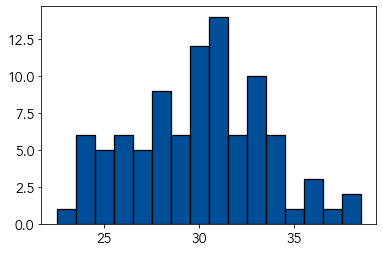

53.76% of Midfielders and Forwards are 30 and under (min 20 90s played)


In [63]:
vals = df_pos_p90['age']
plt.hist(vals,bins=np.arange(vals.min(),vals.max()+1,1),align='left')
plt.show()
print("{:.2f}% of Midfielders and Forwards are 30 and under (min 20 90s played)".format((len(vals[vals <= 30]) / len(vals))*100))

### Top Players

Let's start with the top players - those which will come in with the purpose of making an immediate impact. We want those which have played a considerable amount of minutes - I will take at least 20 90s. While age is less important in this category, it is still important to consider - older players may not be able to keep performing to such a high level. Hence, I will just look at players 30 years old and younger.

In [64]:
df_pos_p90, df_pos_p90_per = get_df_pos(df,wing_attr_key,nineties=20,age_range=(0,30),exclude_pos=['Goalkeeper','Defender'])

Find the top 20 players judging by all attributes. Then look at specific strengths from there.

In [65]:
top = df_pos_p90_per[wing_attr_key].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_top = df_pos_p90.loc[top]
df_top_per = df_pos_p90_per.loc[top]

In [66]:
df_top_per;

### All-round

With the top 20 overall in hand we can now focus on specific strengths. First, the broad range of *Shooting*, *Dribbling* and *Creating* - so excluding *Crossing* and *Possession Losses*.

In [67]:
df_top_per.loc[df_top_per[wing_shot_attr+wing_drib_attr+wing_creat_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index];

In [68]:
df_players.loc[df_top_per[wing_shot_attr+wing_creat_attr+wing_drib_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index];

Certainly some exciting players. 
- PID 61278 stands out as consistently at the top of rankings and 28 years old. Likely one of the best wingers in the league and playing a lot of games. Hence, probably already plays for a top club and would be expensive to sign. But if possible, would be one of the best signings.
- PID 86398 also stands out acroos the board but is 30. Not as much of a shooter but a very good creator - although does not spend a lot of time in the box.
- **PID 119718** looks interesting. High on this list and only 26. Looking at his rankings it is clear his strengths are shooting and dribbling, although his success is quite low. Likes to push high up the pitch with a large amount of touches in the penalty area. This looks like an excellent signing, especially if you a not a really passing-focused team but still looks competent there.
- PID 88484 is an incredible creator and decent shooter but nothing exceptional. Also crosses a LOT but is not a prolific dribbler.
- PID 76012 is on the younger end of this list at 27 but is ranked highly. Excellent dribbler paired with good creation but average goal-threat.
- **PID 108438** is young and is a serious goal-threat coupled with good creation. Not the most accomplished dribbler.
- **PID 76650** great goal threat (along with taking mostly good xG/shot) and dangerous creator - particularly from through balls. Not a dribbler and not particularly young at 29.
- PID 156689 incredibly young at 24 with suggests a real prospect. Likes to take many shots but from poor positions. Good creator and very accomplished dribbler.

### Crosser

What if you're looking for someone with a focus of creating space on the wing and just crossing? For this we would focus on the *dribbling* and *crossing* attributes.

In [69]:
df_top_per.loc[df_top_per[wing_drib_attr+wing_cross_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index];

In [70]:
df_players.loc[df_top_per[wing_cross_attr+wing_drib_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index];

- **PID 156689** The first player on this list under the age of 28 and at 24 is very young. Attempts a lot of dribbles with decent success and a lot of crosses, although success there is not as high. Also a competent creator - although many on this list are.

#### Prospects

In [71]:
df_pos_p90, df_pos_p90_per = get_df_pos(df,wing_attr_key,nineties=10,age_range=(0,24),exclude_pos=['Goalkeeper','Defender'])

In [72]:
len(df_pos_p90)

15

In [73]:
df_players.loc[df_pos_p90.index]['age'].unique()

array([23, 24])

There are only 15 players 24 and under who have played at least 10 90s and they are either 23 or 24 years old. Like before, find the top judging by all attributes then look at specific strengths from there.

In [74]:
top = df_pos_p90_per[wing_attr_key].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_top = df_pos_p90[wing_attr_key].loc[top]
df_top_per = df_pos_p90_per[wing_attr_key].loc[top]

Now focusing on the top 10 in the maing attributes of *Shooting*, *Dribbling* and *Creation*.

In [75]:
df_top_per.loc[df_top_per[wing_shot_attr+wing_drib_attr+wing_creat_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index];

In [76]:
df_players.loc[df_top_per.loc[df_top_per[wing_shot_attr+wing_drib_attr+wing_creat_attr].sum(axis=1).sort_values(ascending=False).iloc[:10].index].index];

- **PID 156689**, who was highlighted above, naturally again appears here and would likely be the best all-round pick here. However, they are not a very competent shooter - while taking a lot of shots they are typically from poor positions.
- **PID 174292** - my recommendation. Excellent all-round, having good shooting which PID 156689 does not have. However, has only played ~12 90s which is not a big sample.

## Centre Back

When looking at defensive metrics it is becomes harder to definitively say what is good - it is more stylistic. One big issue is teams that have less possession will have more defending to do and therefore their players will tend to perform more defensive actions.

One way to get around this is to adjust the defensive statistics by the possession the team has. Then players should be able to be compared defensively on a more equal footing. 

From there it is still not a case of "*more tackles means a better defender*". It is more of a case of style, as mentioned. A defender with higher attempted tackle total likes to engage more - whether this is personal of team instructions. Tackle success % is a measure to show how successful they are.

Variables that need to be possession adjusted are *total_tackle*, *won_tackle*, *aerial_won*, *aerial_lost*, *interception*, *total_clearance*. However, I will likely use *won_tackle* to calculate *tackle %* and *aerial_lost* to calculate *aerial %* so do that before possession adjusting.

In [77]:
cb_attr = ['touches','ball_recovery','blocked_pass','total_tackle_adj','tackle%','aerial_won_adj','aerial%',
           'interception_adj','fouls','error_lead_to_goal','error_lead_to_shot','total_clearance_adj','final_third_entries',
           'poss_lost_all','total_pass','total_long_balls','long_ball_to_pass%']

In [78]:
df_def_p90, df_def_p90_per = get_df_pos(df_adj,cb_attr,nineties=20,exclude_pos=['Goalkeeper','Midfielder','Forward'])

Let's take a quick look at the age profile of defenders who have played at least 20 90s.

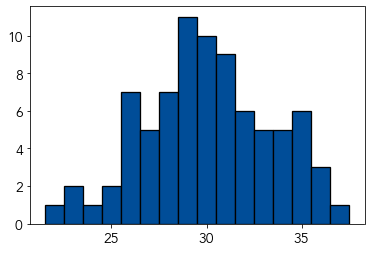

56.79% of Defenders are 30 and under (min 20 90s played)


In [79]:
vals = df_def_p90['age']
plt.hist(vals,bins=np.arange(vals.min(),vals.max()+1,1),align='left')
plt.show()
print("{:.2f}% of Defenders are 30 and under (min 20 90s played)".format((len(vals[vals <= 30]) / len(vals))*100))

We see the most common ages are 29 and 30 and most defenders are within 4 years of 30. While the peak age range of defenders may tend to be higher than other positions, I will again only consider players 30 and under.

Finally, let's choose the key attributes.

In [117]:
cb_attr_key = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj','final_third_entries',
               'poss_lost_all','error_lead_to_shot','fouls',
              'total_pass','total_long_balls','long_ball_to_pass%']

I looked at including *total_through_ball* but defenders barely play any so it was not a great indicator of ball-playing style. Also similar for *total_contest*.

In [118]:
cb_tackle_attr = ['total_tackle_adj','tackle%']
cb_aerial_attr = ['aerial_won_adj','aerial%']
cb_inter_attr = ['interception_adj']
cb_pass_attr = ['final_third_entries']

#### Top Players

In [119]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,cb_attr_key,nineties=20,age_range=(0,32),exclude_pos=['Goalkeeper','Midfielder','Forward'])

Keep in mind for the next line of code that ``df_fbcb_pca`` is currently computed at the bottom of this notebook. Just bring the *fb* column as this really seems to determine if someone is a FB. I will take only negative values for *fb* to try to exclude as many FBs as possible.

In [120]:
df_pos_p90 = pd.merge(df_pos_p90,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)

In [121]:
df_pos_p90_per = pd.merge(df_pos_p90_per,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)

In [122]:
print("Total number of defenders:",len(df_pos_p90_per))
print("Total number of centre backs:",len(df_pos_p90_per[df_pos_p90_per['fb'] <= 0]))

Total number of defenders: 61
Total number of centre backs: 30


Excluding what I believe to be mostly FBs has almost cut available players in half. I think this makes sense, you wouldn't really expect most clubs to have more than 20 CBs make more than 20 90s.

In [123]:
df_pos_p90 = df_pos_p90[df_pos_p90['fb'] <= 0].copy()
df_pos_p90_per = df_pos_p90_per[df_pos_p90_per['fb'] <= 0].copy()

In [97]:
len(df_pos_p90[df_pos_p90['error_lead_to_shot'] == 0])

23

It is important to realise that 30/44 of these defenders have zero errors leading to shot! Have to decide how to deal with this percentile as then the top percentile becomes 64.77%. If I change the percentile type to ``strict`` then I get 100 for the top score but then immediately the next best score is 31.81% so this doesn't really seem fair. I don't think I will use *error_lead_to_shot* to shortlist players but will look at it once I have my shortlist.

In [98]:
100-stats.percentileofscore(df_pos_p90['error_lead_to_shot'].to_numpy(),0.001,kind='strict')

23.33333333333333

### Tackling and Aerial

Tackling and Aerial ability are the two main defending skills we can get from this data, alongside possilby Interceptions. I will find the defenders that rate highest in Tackling and Aerial abilities then choose a shortlist from there based on *age*, *interceptions* and style choices such as *final_third_entries*, *total_pass* and *long_ball_to_pass%* to understand how comfortable they are passing/progressing the ball. Finally, can look at errors such as *poss_lost_all*, *error_lead_to_shot* and *fouls* to judge the all-round package.

In [99]:
top = df_pos_p90_per[cb_tackle_attr + cb_aerial_attr].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_pos_p90_per.loc[top];

- **PID 88580** ranks highest for Tackling and Aerial and is only 26. This looks to be the best candidate. Also has high levels of Interceptions and makes the most passes of anyone with a very low proportion of long balls (but need to compare to team style). While they very rarely give the ball away, they are not the most progressive with very few Final Third Entries and actually has quite a high number of Errors Leading to Shots. Also isn't always a starter in his team.
- **PID 146941** 4th on this list but again only 26. Not such an accomplished Tackler but decent. Very good Aerial Ability and bit more progressive in terms of Final Third Entries. Again makes a lot of passes however, this time attempts many more long balls. However, has great possession loss numbers despite quite a large portion of long balls. This suggests someone who is comfortable and calm on the ball and an accurate long passer.
- **PID 197319** 5th and only 25. Good tackler but not so good Aerially. Participates in a lot of Aerial Duels but hasn't got such a good win rate. Looks to be a front-foot defender with the most interceptions of any of these CBs. Also plays a good amount of Passes with very high Final Third Entries - however this could be a product of the number of Long Balls they play, which, compared to the other CBs, is a very high proportion of their passes.
- **PID 90152** 6th and 27. Not such an accomplished *tackler* but incredible *aerially*. Also *retains possession* very well and makes a large number of *passes*, not too many of which are *long balls*. So looks very comfortable in possession, as needed by a top Champions League side.

### Prospect

There are only 3 CBs 24 and under that have played at least 10 90s! I think I need to increase the age range slightly, so I will look at those 26 and under. In this case there are 12 CBs.

In [100]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,cb_attr_key,nineties=10,age_range=(0,26),exclude_pos=['Goalkeeper','Midfielder','Forward'])

In [101]:
df_pos_p90 = pd.merge(df_pos_p90,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)

In [102]:
df_pos_p90_per = pd.merge(df_pos_p90_per,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)

In [103]:
print("Total number of defenders:",len(df_pos_p90_per))
print("Total number of centre backs:",len(df_pos_p90_per[df_pos_p90_per['fb'] <= 0]))

Total number of defenders: 24
Total number of centre backs: 12


In [104]:
df_pos_p90 = df_pos_p90[df_pos_p90['fb'] <= 0].copy()
df_pos_p90_per = df_pos_p90_per[df_pos_p90_per['fb'] <= 0].copy()

In [105]:
top = df_pos_p90_per[cb_tackle_attr + cb_aerial_attr].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_pos_p90_per.loc[top];

The three recommendations above all appear again and seem to be the best picks. One player ranks above them but has only played 11.2 90s:
- **PID 151883** Very active Tackler with decent success rate. Very accomplished in the Air and good Interceptions. Also seems quite progressive with high Final Third Entries however, this could be due to the very large proportion of Long Balls they play.

### Plots

What attributes are important for style of CB? This is looking at quantity rather than quality. I want to judge who tackles, aerial duels, intercepts, is comfortable passing, long passes, fouling, error prone. *Tackles*, *Aerial Duels*, *Interceptions*, *total_pass*, *total_long_balls*, *fouls*.

It is hard to judge progression and possession retention as both *final_third_entries* and *poss_lost_all* are related to *long_ball_to_pass%*.

In [124]:
cb_attr_plot = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj','fouls','poss_lost_all']

In [1996]:
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [125]:
tackle_attr = ['total_tackle_adj']
aerial_attr = ['aerial_won_adj']
inter_attr = ['interception_adj']
pass_attr = ['total_pass']
long_attr = ['total_long_balls']
foul_attr = ['fouls']
style_attr_cb = [tackle_attr,aerial_attr,inter_attr,pass_attr,long_attr,foul_attr]

In [126]:
df_style_cb = get_df_style(df_adj,style_attr_cb,styles=['tackle','aerial','inter','pass','long','foul'],
             exclude_pos=['Goalkeeper','Midfielder','Forward'])

In [127]:
df_style_cb = get_df_style(df_adj,style_attr_cb,styles=['tackle','aerial','inter','pass','long','foul'],
             exclude_pos=['Goalkeeper','Midfielder','Forward'],special_pos='Centre Back')

In [128]:
df_style_team = get_df_style(df_adj,style_attr_cb,styles=['tackle','aerial','inter','pass','long','foul'],
             exclude_pos=['Goalkeeper','Midfielder','Forward'],team=True)

In [129]:
cb_shortlist = [88580,146941,90152]

In [130]:
test = plt.get_cmap('Set2')

In [131]:
test.colors

((0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254))

In [132]:
#from palettable.cartocolors.diverging import Temps_7_r
from palettable.cartocolors.qualitative import Pastel_8
from palettable.cartocolors.sequential import Sunset_7,OrYel_7,PinkYl_7,RedOr_7
from palettable.cmocean.sequential import Deep_8
from palettable.colorbrewer.diverging import Spectral_3,Spectral_7,RdYlGn_3,RdYlGn_9
from palettable.scientific.sequential import LaJolla_8
from palettable.tableau import GreenOrange_6,TableauLight_10

Top choices for *style_colors*: *Sunset_7*, *OrYel_7*, *Deep_8*, *LaJolla_8*.

In [133]:
RdYlGn_9.mpl_colors[-1]

(0.10196078431372549, 0.596078431372549, 0.3137254901960784)

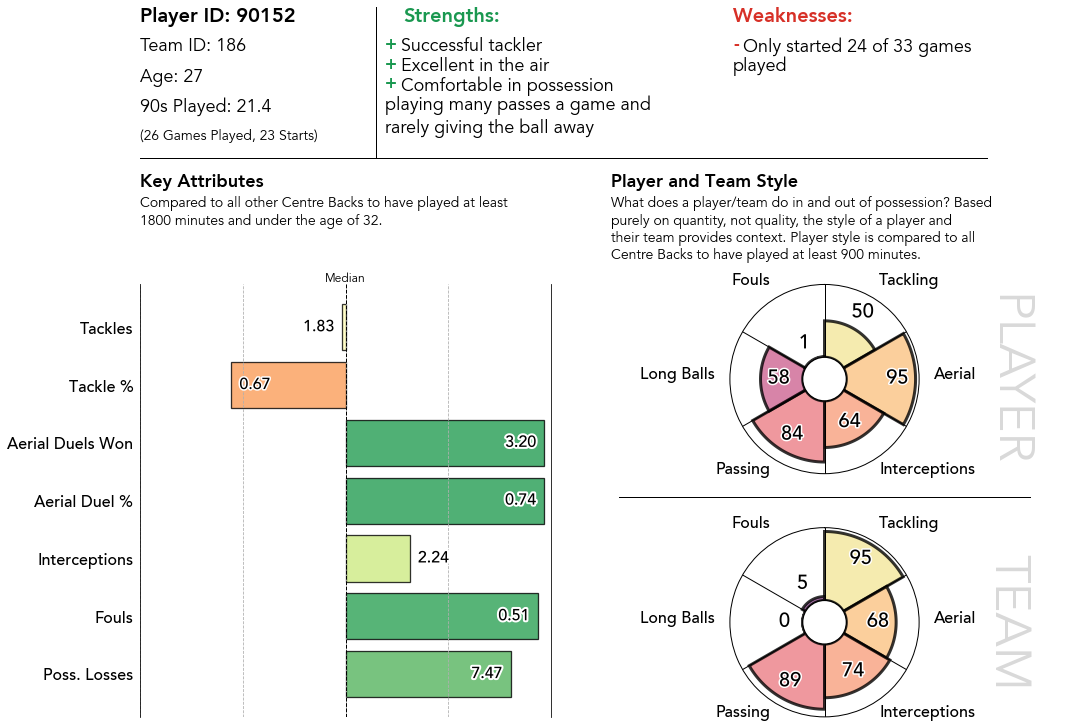

In [134]:
pid = cb_shortlist[2]
tid = df[df['player_id'] == pid]['team_id'].iloc[0]
b_cmap = RdYlGn_9.mpl_colormap
style_colors = Sunset_7.mpl_colors

fig = plt.figure(figsize=(15,10),constrained_layout=True)
gs = fig.add_gridspec(4, 2,width_ratios=[0.8,1],height_ratios=[0.8,1,0.1,1])#,wspace=-0.02,hspace=0.5)#width_ratios=[0.75,1]

ax_head = fig.add_subplot(gs[0, :])
ax_head.axis('off')
ax1 = fig.add_subplot(gs[1:, 0])
ax2 = fig.add_subplot(gs[1, 1],projection='polar')
ax3 = fig.add_subplot(gs[3, 1],projection='polar')

line = lines.Line2D([0.,0.9], [0.,0.], lw=1.,color='k',clip_on=False,transform=ax_head.transAxes)
ax_head.add_line(line)

ax_gap = fig.add_subplot(gs[2, 1])
ax_gap.axis('off')
line = lines.Line2D([0.1,0.9], [0.5,0.5], lw=1.,color='k',clip_on=False,transform=ax_gap.transAxes)
ax_gap.add_line(line)

tfrm = ax_head.transAxes
# Heading info
ax_head.set_xlim(0,1)
ax_head.set_ylim(0,1)
ax_head.text(0.,1,f"Player ID: {pid}",transform=tfrm,size=20,weight='bold',ha='left',va='top')
ax_head.text(0.,0.8,f"Team ID: {tid}",transform=tfrm,size=18,weight='normal',ha='left',va='top')
ax_head.text(0,0.6,"Age: {}".format(df_players.loc[pid,'age']),transform=tfrm,size=18,weight='normal',ha='left',va='top')
ax_head.text(0,0.4,"90s Played: {:.1f}".format(df_players.loc[pid,'90s']),transform=tfrm,size=18,weight='normal',ha='left',va='top')
ax_head.text(0,0.2,f"({df_players.loc[pid,'gp']} Games Played, {df_players.loc[pid,'games_started']} Starts)",transform=tfrm,size=14,weight='normal',ha='left',va='top')

#Strengths and Weaknesses
line = lines.Line2D([0.25,0.25], [0.,1.], lw=1.,color='k',clip_on=False,transform=tfrm)
ax_head.add_line(line)
htext(s='<Strengths:>',x=0.28,y=1,highlight_colors = [mpl.colors.to_hex(RdYlGn_9.mpl_colors[-1])],highlight_weights=['bold'],ha='left',va='top',size=20,ax=ax_head)#,path_effects=[patheffects.withStroke(linewidth=0.1,foreground="k")])
t = "<+> Successful tackler\n<+> Excellent in the air\n<+> Comfortable in possession playing many passes a game and rarely giving the ball away"
t = '\n'.join([fill(line,35) for line in t.splitlines() if line.strip() != ''])
htext(s=t,x=0.26,y=0.8,highlight_colors = [mpl.colors.to_hex(RdYlGn_9.mpl_colors[-1])],highlight_weights=['bold'],ha='left',va='top',size=18,ax=ax_head)
htext(s='<Weaknesses:>',x=0.63,y=1,highlight_colors = [mpl.colors.to_hex(RdYlGn_9.mpl_colors[0])],highlight_weights=['bold'],ha='left',va='top',size=20,ax=ax_head)
t = "<-> Only started 24 of 33 games played"
t = '\n'.join([fill(line,35) for line in t.splitlines() if line.strip() != ''])
htext(s=t,x=0.63,y=0.8,highlight_colors = [mpl.colors.to_hex(RdYlGn_9.mpl_colors[0])],highlight_weights=['bold'],ha='left',va='top',size=18,ax=ax_head)

# Plot headings
ax_head.text(0,-0.1,"Key Attributes",transform=tfrm,size=18,weight='bold',ha='left',va='top')
t = 'Compared to all other Centre Backs to have played at least 1800 minutes and under the age of 32.'
ax_head.text(0.,-0.25,fill(t,60),transform=tfrm,size=14,ha='left',va='top')
ax_head.text(0.5,-0.1,"Player and Team Style",transform=tfrm,size=18,weight='bold',ha='left',va='top')
t = "What does a player/team do in and out of possession? Based purely on quantity, not quality, the style of a player and their team provides context. Player style is compared to all Centre Backs to have played at least 900 minutes."
ax_head.text(0.5,-0.25,fill(t,60),transform=tfrm,size=14,ha='left',va='top')


tfrm = ax1.transAxes
attr_labels = ['Tackles','Tackle %','Aerial Duels Won','Aerial Duel %','Interceptions','Fouls','Poss. Losses']
ax1 = plot_bars(df_players,df_pos_p90,df_pos_p90_per,cb_attr_plot,pid,attr_labels=attr_labels,annotations=False,ax=ax1,
               bar_cmap=b_cmap)
#ax1.annotate('Key Attributes',(0.,1.2),xycoords='axes fraction',annotation_clip=False,fontsize=18,fontweight='bold')
#t = 'Compared to all other Centre Backs to have played at least 1800 minutes and under the age of 32.'
#ax1.text(0.,1.1,fill(t,55),transform=ax1.transAxes,fontsize=14)
#ax1.text(1,0.5,'test',transform=tfrm,size=18)

tfrm = ax2.transAxes
labels = ['Tackling','Aerial','Interceptions','Passing','Long Balls','Fouls']
ax2 = plot_style(df_style_cb,pid,labels=labels,ax=ax2,colors=style_colors)
#ax2.text(0.5,1.2,"Player Style",transform=tfrm,size=18,weight='bold',ha='center',va='bottom')
ax2.text(1.6,0.5,"PLAYER",transform=tfrm,rotation=-90,size=50,c='0.5',alpha=0.3,ha='right',va='center')

tfrm = ax3.transAxes
ax3 = plot_style(df_style_team,tid,labels=labels,ax=ax3,colors=style_colors)
#ax3.text(0.5,1.2,"Team Style",transform=tfrm,size=18,weight='bold',ha='center',va='bottom')
ax3.text(1.6,0.5,"TEAM",transform=tfrm,rotation=-90,size=50,c='0.5',alpha=0.3,ha='right',va='center')

#plt.tight_layout()
#fig.savefig("test.png")
plt.show()

## Defensive Midfielder

In [135]:
dm_attr = ['touches','ball_recovery','blocked_pass','total_tackle_adj','tackle%','aerial_won_adj','aerial%',
           'interception_adj','fouls','error_lead_to_goal','error_lead_to_shot','total_clearance_adj','final_third_entries','pen_area_entries',
           'poss_lost_all','total_pass','pass%','total_long_balls','long_ball_to_pass%','total_through_ball','total_att_assist',
          'won_contest','total_contest','total_scoring_att','expected_goals']

In [136]:
df_dm_p90, df_dm_p90_per = get_df_pos(df_adj,dm_attr,nineties=20,exclude_pos=['Goalkeeper','Defender','Forward'])
print("There are {} Midfielders who have played at least 20 90s.".format(len(df_dm_p90)))

There are 65 Midfielders who have played at least 20 90s.


Let's take a quick look at the age profile of defenders who have played at least 20 90s.

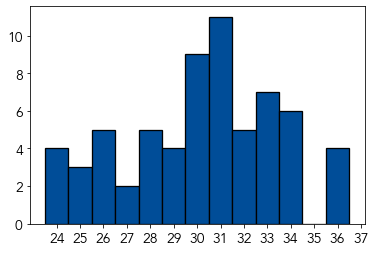

49.23% of Midfielders are 30 and under (min 20 90s played)


In [137]:
vals = df_dm_p90['age']
plt.hist(vals,bins=np.arange(vals.min(),vals.max()+1,1),align='left')
plt.xticks(np.arange(vals.min(),vals.max()+1,1))
plt.show()
print("{:.2f}% of Midfielders are 30 and under (min 20 90s played)".format((len(vals[vals <= 30]) / len(vals))*100))

Most common ages are 30 and 31. Just under half are 30 and below, so it should be ok to again look for players 30 and under.

Finally, let's choose the key attributes.

In [138]:
dm_attr_key = ['ball_recovery','blocked_pass','total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj',
               'final_third_entries','pen_area_entries','poss_lost_all','fouls',
              'total_pass','long_ball_to_pass%','total_through_ball','total_att_assist','total_contest','contest%',
              'total_scoring_att','expected_goals']

In [139]:
dm_tackle_attr = ['total_tackle_adj','tackle%']
dm_aerial_attr = ['aerial_won_adj','aerial%']
dm_inter_attr = ['interception_adj']
dm_pass_attr = ['total_pass','total_through_ball']
dm_creat_attr = ['final_third_entries','total_att_assist']
dm_drib_attr = ['total_contest','contest%']
dm_shot_attr = ['total_scoring_att','expected_goals']

In [140]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,dm_attr_key,nineties=20,age_range=(0,30),exclude_pos=['Goalkeeper','Defender','Forward'])

In [141]:
top = df_pos_p90_per[dm_attr_key].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_pos_p90_per.loc[top];

### Disrupters

In [142]:
dist_attr = dm_tackle_attr + dm_aerial_attr + dm_inter_attr
top = df_pos_p90_per[dist_attr].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_pos_p90_per.loc[top];

- **PID 192364** 7th on this list, only 25 and started 31 games. Strong recovery and blocked passes, decent Tackling with high amount but not the best success rate, very good aerially. Also great at Intercepting and decent progressing to Final Third. Holds onto the ball well and seems comfortable passing, although likes to play a lot of long balls. Not a Shooter.
- **PID 89335** (Top pick) 5th and again 25 with 29 starts. Very similar defensively to PID 192364 although involved in many more aerial engagements but with a slightly lower success rate. Slightly better at progressin the ball and is therefore seems to be a bit more risky with passing, reflected in more possession losses. Doesn't pass as much but plays far fewer long balls. This progressive passing can be seen in a high amount of attempted *through balls*. Likes to dribble more and shoots quite a bit.

### Deep-lying passers/playmakers

In [143]:
play_attr = dm_tackle_attr + dm_pass_attr + dm_creat_attr #+ dm_shot_attr
top = df_pos_p90_per[play_attr].sum(axis=1).sort_values(ascending=False).iloc[:20].index
df_pos_p90_per.loc[top][:10];

- **PID 77390** 2nd, 28 and 36 starts. Good *Tackler* and while has good success rate *aerially*, does not get involved in many duels (but not perticularly important for this role. Excellent *final third* and *penalty area* entries, plays many passes (middle of the road for long ball amount), a lot of *through balls* and *key passes*. Not a very active *shooter*.
- **PID 182539** 5th, 24 and 24 starts. Interestingly top for *ball recovery* and *blocked passes*. Good *tackler* but again not particularly *aerially* good. Good *interceptions* as well so can do a decent job defensively. Great *final third* entries and decent *penalty area* entries, so good progressor. Used to playing a good amount of passes, but quite a few long. Good amount of *through balls* and *key passes*. Also someone who likes to *dribble* and has decent success, unlike PID 77390. Takes on more *shooting* oppportunities but tend to be from lower quality positions.

## Final Combined Graphic

In [144]:
def player_overview_plot(pid,df,df_players,df_pos_p90,df_pos_p90_per,strength_text,weak_text,key_text,style_text,
                         b_cmap=RdYlGn_9.mpl_colormap,style_colors=Sunset_7.mpl_colors):

    tid = df[df['player_id'] == pid]['team_id'].iloc[0]

    fig = plt.figure(figsize=(15,10),constrained_layout=True)
    gs = fig.add_gridspec(4,2,width_ratios=[1,0.8],height_ratios=[0.8,1,0.1,1])#,wspace=-0.02,hspace=0.5)#width_ratios=[0.75,1]

    ax_head = fig.add_subplot(gs[0, :])
    ax_head.axis('off')
    ax1 = fig.add_subplot(gs[1:, 0])
    ax2 = fig.add_subplot(gs[1, 1],projection='polar')
    ax3 = fig.add_subplot(gs[3, 1],projection='polar')

    line = lines.Line2D([0.,0.9], [0.,0.], lw=1.,color='k',clip_on=False,transform=ax_head.transAxes)
    ax_head.add_line(line)

    ax_gap = fig.add_subplot(gs[2, 1])
    ax_gap.axis('off')
    line = lines.Line2D([0.1,0.9], [0.5,0.5], lw=1.,color='k',clip_on=False,transform=ax_gap.transAxes)
    ax_gap.add_line(line)

    tfrm = ax_head.transAxes
    # Heading info
    ax_head.set_xlim(0,1)
    ax_head.set_ylim(0,1)
    ax_head.text(0.,1,f"Player ID: {pid}",transform=tfrm,size=20,weight='bold',ha='left',va='top')
    ax_head.text(0.,0.8,f"Team ID: {tid}",transform=tfrm,size=18,weight='normal',ha='left',va='top')
    ax_head.text(0,0.6,"Age: {}".format(df_players.loc[pid,'age']),transform=tfrm,size=18,weight='normal',ha='left',va='top')
    ax_head.text(0,0.4,"90s Played: {:.1f}".format(df_players.loc[pid,'90s']),transform=tfrm,size=18,weight='normal',ha='left',va='top')
    ax_head.text(0,0.2,f"({df_players.loc[pid,'gp']} Games Played, {df_players.loc[pid,'games_started']} Starts)",transform=tfrm,size=14,weight='normal',ha='left',va='top')

    #Strengths and Weaknesses
    line = lines.Line2D([0.25,0.25], [0.,1.], lw=1.,color='k',clip_on=False,transform=tfrm)
    ax_head.add_line(line)
    htext(s='<Strengths:>',x=0.28,y=1,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[-1])],highlight_weights=['bold'],ha='left',va='top',size=20,ax=ax_head)#,path_effects=[patheffects.withStroke(linewidth=0.1,foreground="k")])
    #t = "<+> Successful tackler\n<+> Excellent in the air\n<+> Comfortable in possession playing many passes a game and rarely giving the ball away"
    t = '\n'.join([fill(line,35) for line in strength_text.splitlines() if line.strip() != ''])
    htext(s=t,x=0.26,y=0.8,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[-1])],highlight_weights=['bold'],ha='left',va='top',size=18,ax=ax_head)
    htext(s='<Weaknesses:>',x=0.63,y=1,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[0])],highlight_weights=['bold'],ha='left',va='top',size=20,ax=ax_head)
    #t = "<-> Only started 24 of 33 games played"
    t = '\n'.join([fill(line,35) for line in weak_text.splitlines() if line.strip() != ''])
    htext(s=t,x=0.63,y=0.8,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[0])],highlight_weights=['bold'],ha='left',va='top',size=18,ax=ax_head)

    # Plot headings
    ax_head.text(0,-0.1,"Key Attributes",transform=tfrm,size=18,weight='bold',ha='left',va='top')
    #t = 'Compared to all other Centre Backs to have played at least 1800 minutes and under the age of 32.'
    ax_head.text(0.,-0.25,fill(key_text,60),transform=tfrm,size=14,ha='left',va='top')
    ax_head.text(0.5,-0.1,"Player and Team Style",transform=tfrm,size=18,weight='bold',ha='left',va='top')
    #t = "What does a player/team do in and out of possession? Based purely on quantity, not quality, the style of a player and their team provides context. Player style is compared to all Centre Backs to have played at least 900 minutes."
    ax_head.text(0.5,-0.25,fill(style_text,60),transform=tfrm,size=14,ha='left',va='top')

    # Bar plot
    tfrm = ax1.transAxes
    attr_labels = ['Tackles','Tackle %','Aerial Duels Won','Aerial Duel %','Interceptions','Fouls','Poss. Losses']
    ax1 = plot_bars(df_players,df_pos_p90,df_pos_p90_per,cb_attr_plot,pid,attr_labels=attr_labels,annotations=False,ax=ax1,
                   bar_cmap=b_cmap)

    # Player style
    tfrm = ax2.transAxes
    labels = ['Tackling','Aerial','Interceptions','Passing','Long Balls','Fouls']
    ax2 = plot_style(df_style_cb,pid,labels=labels,ax=ax2,colors=style_colors)
    ax2.text(1.6,0.5,"PLAYER",transform=tfrm,rotation=-90,size=50,c='0.5',alpha=0.3,ha='right',va='center')

    # Team style
    tfrm = ax3.transAxes
    ax3 = plot_style(df_style_team,tid,labels=labels,ax=ax3,colors=style_colors)
    ax3.text(1.6,0.5,"TEAM",transform=tfrm,rotation=-90,size=50,c='0.5',alpha=0.3,ha='right',va='center')

    #plt.tight_layout()
    #fig.savefig("test.png")
    plt.show()

In [145]:
cb_attr_key = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj','final_third_entries',
               'poss_lost_all','error_lead_to_shot','fouls',
              'total_pass','total_long_balls','long_ball_to_pass%']

In [146]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,cb_attr_key,nineties=20,age_range=(0,32),exclude_pos=['Goalkeeper','Midfielder','Forward'])

Keep in mind for the next line of code that ``df_fbcb_pca`` is currently computed at the bottom of this notebook. Just bring the *fb* column as this really seems to determine if someone is a FB. I will take only negative values for *fb* to try to exclude as many FBs as possible.

In [147]:
df_pos_p90 = pd.merge(df_pos_p90,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
df_pos_p90_per = pd.merge(df_pos_p90_per,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)

In [148]:
df_pos_p90 = df_pos_p90[df_pos_p90['fb'] <= 0].copy()
df_pos_p90_per = df_pos_p90_per[df_pos_p90_per['fb'] <= 0].copy()

In [ ]:
style_text = "What does a player/team do in and out of possession? Based purely on quantity, not quality, the style of a player and their team provides context. Player style is compared to all Centre Backs to have played at least 900 minutes."

In [599]:
strength_text = "<+> Successful tackler\n<+> Excellent in the air\n<+> Comfortable in possession"
weak_text = u"<\u2212> Only started 24 of 33 games played"
key_text = 'Compared to all other Centre Backs to have played at least 1800 minutes and under the age of 32.'
style_text = "Player style is compared to all Centre Backs to have played at least 900 minutes."

When using ``htext`` have to create all the axes first and then use it. If you don't then constrained_layout doesn't work correctly.

In [218]:
plt.rcParams['pdf.fonttype'] = 42

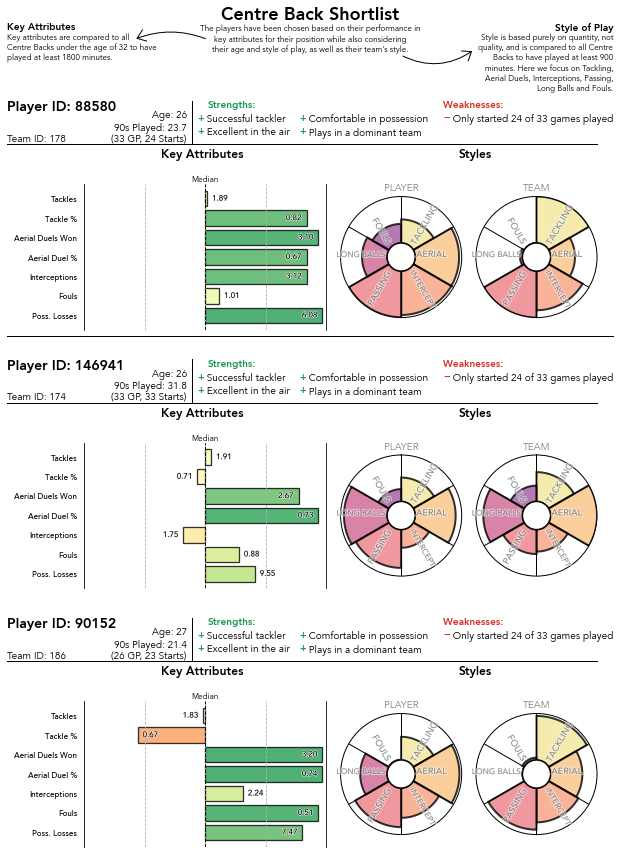

In [601]:
# Trying side-by-side style plots

strength_text = "<+> Successful tackler\n<+> Excellent in the air"
weak_text = u"<\u2212> Only started 24 of 33 games played"
key_text = 'Compared to all other Centre Backs to have played at least 1800 minutes and under the age of 32.'
style_text = "Player style is compared to all Centre Backs to have played at least 900 minutes."

fig = plt.figure(figsize=(8.5,11.75),constrained_layout=True)
#gs0 = fig.add_gridspec(4, 1,height_ratios=[0.2,1,1,1])#,hspace=0.5)
gs0 = fig.add_gridspec(6, 1,height_ratios=[0.4,1,0.1,1,0.1,1])#,hspace=0.5)

pos = 'Centre Back'
pid = [88580,146941,90152]

gs = gs0[0].subgridspec(1,1)
ax_title = fig.add_subplot(gs[:])
gs = gs0[2].subgridspec(1,1)
ax_gap1 = fig.add_subplot(gs[:])
gs = gs0[4].subgridspec(1,1)
ax_gap2 = fig.add_subplot(gs[:])

ax_title.axis('off')
ax_title.set_xlim(0,1)
ax_title.set_ylim(0,1)

ax_gap1.axis('off')
line = lines.Line2D([0,1.0], [1.,1.], lw=1.,color='k',clip_on=False,transform=ax_gap1.transAxes)
ax_gap1.add_line(line)

ax_gap2.axis('off')

ax_heads = []
ax1s = []
ax2s = []
ax3s = []
ax_gaps = []
ax_gaps2 = []
# Initialise all subplots first
for i in [1,3,5]:
    gs = gs0[i].subgridspec(2,3,width_ratios=[1,0.5,0.5],height_ratios=[0.3,1])
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[1,1],projection='polar')
    ax3 = fig.add_subplot(gs[1,2],projection='polar')
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)
    #ax_gaps.append(ax_gap)
    #ax_gaps2.append(ax_gap2)
    
"""for i in range(1,4):
    gs = gs0[i].subgridspec(3,3,width_ratios=[1,0.5,0.5],height_ratios=[0.3,1,0.2])
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[1,1],projection='polar')
    #ax_gap = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[1,2],projection='polar')
    ax_gap2 = fig.add_subplot(gs[2,:])
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)
    #ax_gaps.append(ax_gap)
    ax_gaps2.append(ax_gap2)"""
    
"""for i in range(1,4):
    gs = gs0[i].subgridspec(4,3,width_ratios=[1,0.5,0.5],height_ratios=[0.3,0.1,1,0.2])
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1:3,0])
    ax2 = fig.add_subplot(gs[2,1],projection='polar')
    ax_gap = fig.add_subplot(gs[1,1:3])
    ax3 = fig.add_subplot(gs[2,2],projection='polar')
    ax_gap2 = fig.add_subplot(gs[3,:])
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)
    ax_gaps.append(ax_gap)
    ax_gaps2.append(ax_gap2)"""

tfrm = ax_title.transAxes
ax_title.text(0.5,1,"Centre Back Shortlist",transform=tfrm,size=18,weight='bold',ha='center',va='top')
t = f"The players have been chosen based on their performance in key attributes for their position while also considering their age and style of play, as well as their team's style."
ax_title.text(0.5,0.8,fill(t,60),transform=tfrm,size=8,ha='center',va='top')

ax_title.text(0,0.82,"Key Attributes",transform=tfrm,size=10,weight='bold',ha='left',va='top')
t = f"Key attributes are compared to all {pos}s under the age of 32 to have played at least 1800 minutes."
ax_title.text(0,0.7,fill(t,40),transform=tfrm,size=8,ha='left',va='top')
arrow1 = FancyArrowPatch((0.33,0.63),(0.21,0.63),connectionstyle="arc3,rad=0.2",arrowstyle="->,head_width=6,head_length=8",transform=tfrm,lw=1,clip_on=False)
ax_title.add_patch(arrow1)

ax_title.text(1,0.82,"Style of Play",transform=tfrm,size=10,weight='bold',ha='right',va='top')
t = f"Style is based purely on quantity, not quality, and is compared to all {pos}s to have played at least 900 minutes. Here we focus on Tackling, Aerial Duels, Interceptions, Passing, Long Balls and Fouls."
ax_title.text(1,0.7,fill(t,40),transform=tfrm,size=8,ha='right',va='top')
arrow2 = FancyArrowPatch((0.65,0.45),(0.77,0.51),connectionstyle="arc3,rad=0.3",arrowstyle="->,head_width=6,head_length=8",transform=tfrm,lw=1,clip_on=False)
ax_title.add_patch(arrow2)

for i in range(3):
    ax_head = ax_heads[i]
    ax1 = ax1s[i]
    ax2 = ax2s[i]
    ax3 = ax3s[i]
    #ax_gap = ax_gaps[i]
    #ax_gap.axis('off')
    #ax_gap.set_xlim(0,1)
    #ax_gap.set_ylim(0,1)
    #ax_gap.text(0.5,0.,"Tackles, Aerial, Interceptions, Passes, Long Balls, Fouls",transform=ax_gap.transAxes,ha='center',va='bottom')
    #labels = "<Tackles>, <Aerial>, <Interceptions>, <Passes>, <Long Balls>, <Fouls>"
    #htext(labels,0.5,0,highlight_colors=Sunset_7.mpl_colors[:6],ha='center',va='bottom',size=12,ax=ax_gap,path_effects=[patheffects.withStroke(linewidth=0.1,foreground="k")])
    #ax_gap2 = ax_gaps2[i]
    #ax_gap2.axis('off')
    player_overview_plot_gs(pid[i],df,df_players,df_pos_p90,df_pos_p90_per,strength_text,weak_text,key_text,style_text,ax_head=ax_head,ax1=ax1,ax2=ax2,ax3=ax3)
    
    ax2.text(0.5,1.02,"PLAYER",transform=ax2.transAxes,size=10,c='0.4',alpha=0.8,ha='center',va='bottom')
    ax3.text(0.5,1.02,"TEAM",transform=ax3.transAxes,size=10,c='0.4',alpha=0.8,ha='center',va='bottom')

fig.savefig("test2.pdf")
plt.show()

In [481]:
def plot_style(df_style,pid,colors=None,labels=None,ax=None,fs=12,fss=10,alpha=0.8):
    if ax is None:
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='polar')

    # Plot bars
    bot = 0.3
    radii = df_style.loc[pid].to_numpy()
    theta = np.linspace(np.pi/len(radii),2*np.pi+np.pi/len(radii),len(radii),endpoint=False)
    bars = ax.bar(theta,radii,width=2*np.pi/len(radii),bottom=bot)

    # Set bar properties
    if colors is None:
        colors = ['#f38181', '#fce38a', '#eaffd0', '#95e1d3','#004d98','#f08a5d','#aa96da']
    for i,bar in enumerate(bars):
        bar.set_alpha(alpha)
        bar.set_ec('k')
        bar.set_fc(colors[i])
        bar.set_lw(2)

    # Add thin lines separating sections
    angles = np.linspace(0,2*np.pi,len(radii),endpoint=False)
    for a in angles:
        ax.plot([a,a],[0,1+bot],c='k',lw=1,zorder=1)

    # Add central white circle
    patch = Circle((0,0),radius=bot,fc='w',transform=ax.transProjectionAffine + ax.transAxes,zorder=2)
    ax.add_patch(patch)
    
    path_effects = [patheffects.withStroke(linewidth=2,foreground="w")]
    # Annotations
    for i,ang in enumerate(theta):
        if labels is not None:
            alpha_text = 0.5
            if len(labels[i]) > 8:
                fsl = fss
            else:
                fsl = fs
            if ang <= np.pi/2:
                ax.text(ang,bot+0.02,labels[i],rotation=90-np.degrees(ang),size=fsl,weight='medium',c='0.3',ha='left',path_effects=path_effects,alpha=alpha_text)
            elif ang < np.pi:
                ax.text(ang,bot,labels[i],rotation=90-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='left',va='top',path_effects=path_effects,alpha=alpha_text)
            elif ang < (3*np.pi)/2:
                ax.text(ang,bot,labels[i],rotation=270-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='right',va='top',path_effects=path_effects,alpha=alpha_text)
            elif ang >= (3*np.pi)/2:
                ax.annotate(labels[i],(ang,bot+0.04),rotation=270-np.degrees(ang),size=fsl,c='0.3',weight='medium',ha='right',path_effects=path_effects,alpha=alpha_text)

    ax.set_ylim(0,1+bot)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(theta)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines['polar'].set_visible(True)
    ax.spines['polar'].set_linewidth(1)
    
    return ax

In [600]:
def player_overview_plot_gs(pid,df,df_players,df_pos_p90,df_pos_p90_per,strength_text,weak_text,key_text,style_text,ax_head,ax1,ax2,ax3,ax_gap=None,
                         b_cmap=RdYlGn_9.mpl_colormap,style_colors=Sunset_7.mpl_colors,fs=10):

    tid = df[df['player_id'] == pid]['team_id'].iloc[0]

    ax_head.axis('off')
    line = lines.Line2D([-0.15,1.0], [0.,0.], lw=1.,color='k',clip_on=False,transform=ax_head.transAxes)
    ax_head.add_line(line)

    if ax_gap is not None:
        ax_gap.axis('off')
        line = lines.Line2D([0.1,0.9], [0.5,0.5], lw=1.,color='k',clip_on=False,transform=ax_gap.transAxes)
        ax_gap.add_line(line)

    tfrm = ax_head.transAxes
    # Heading info
    ax_head.set_xlim(0,1)
    ax_head.set_ylim(0,1)
    ax_head.text(-0.15,1,f"Player ID: {pid}",transform=tfrm,size=14,weight='bold',ha='left',va='top')
    ax_head.text(-0.15,0.,f"Team ID: {tid}",transform=tfrm,size=fs,weight='normal',ha='left',va='bottom')
    ax_head.text(0.20,0.54,"Age: {}".format(df_players.loc[pid,'age']),transform=tfrm,size=fs,weight='normal',ha='right',va='bottom')
    ax_head.text(0.20,0.27,"90s Played: {:.1f}".format(df_players.loc[pid,'90s']),transform=tfrm,size=fs,weight='normal',ha='right',va='bottom')
    ax_head.text(0.20,0.,f"({df_players.loc[pid,'gp']} GP, {df_players.loc[pid,'games_started']} Starts)",transform=tfrm,size=fs,weight='normal',ha='right',va='bottom')
    """ax_head.text(0,0.6,"Age: {}".format(df_players.loc[pid,'age']),transform=tfrm,size=fs,weight='normal',ha='left',va='top')
    ax_head.text(0,0.4,"90s Played: {:.1f}".format(df_players.loc[pid,'90s']),transform=tfrm,size=fs,weight='normal',ha='left',va='top')
    ax_head.text(0,0.2,f"({df_players.loc[pid,'gp']} Games Played, {df_players.loc[pid,'games_started']} Starts)",transform=tfrm,size=fs,weight='normal',ha='left',va='top')
"""
    #Strengths and Weaknesses
    line = lines.Line2D([0.21,0.21], [0.,1.], lw=1.,color='k',transform=tfrm)
    ax_head.add_line(line)
    htext(s='<Strengths:>',x=0.24,y=1,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[-1])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)#,path_effects=[patheffects.withStroke(linewidth=0.1,foreground="k")])
    #t = '\n'.join([fill(line,40) for line in strength_text.splitlines() if line.strip() != ''])
    #htext(s=t,x=0.26,y=0.8,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[-1])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)
    y_coords = [0.7,0.4]
    x_coords = [0.22,0.42]
    strength_text_new = ["<+> Successful tackler","<+> Excellent in the air","<+> Comfortable in possession","<+> Plays in a dominant team"]
    for i,t in enumerate(strength_text_new):
        htext(s=t,x=x_coords[i//2],y=y_coords[i%2],highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[-1])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)
    
    htext(s='<Weaknesses:>',x=0.7,y=1,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[0])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)
    y_coords = [0.7,0.4]
    x_coords = [0.7,0.82]
    weak_text_new = [u"<\u2212> Only started 24 of 33 games played"]
    for i,t in enumerate(weak_text_new):
        htext(s=t,x=x_coords[i//2],y=y_coords[i%2],highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[0])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)
    #t = '\n'.join([fill(line,40) for line in weak_text.splitlines() if line.strip() != ''])
    #htext(s=t,x=0.63,y=0.8,highlight_colors=[mpl.colors.to_hex(RdYlGn_9.mpl_colors[0])],highlight_weights=['bold'],ha='left',va='top',size=fs,ax=ax_head)
      
    # Plot headings
    ax_head.text(0.15,-0.1,"Key Attributes",transform=tfrm,size=12,weight='bold',ha='left',va='top')
    #ax_head.text(0.,-0.25,fill(key_text,40),transform=tfrm,size=10,ha='left',va='top')
    ax_head.text(0.73,-0.1,"Styles",transform=tfrm,size=12,weight='bold',ha='left',va='top')
    #ax_head.text(0.5,-0.25,fill(style_text,40),transform=tfrm,size=10,ha='left',va='top')

    # Bar plot
    tfrm = ax1.transAxes
    attr_labels = ['Tackles','Tackle %','Aerial Duels Won','Aerial Duel %','Interceptions','Fouls','Poss. Losses']
    ax1 = plot_bars(df_players,df_pos_p90,df_pos_p90_per,cb_attr_plot,pid,attr_labels=attr_labels,annotations=False,ax=ax1,
                   bar_cmap=b_cmap,fs=8)

    # Player style
    tfrm = ax2.transAxes
    labels = ['TACKLING','AERIAL','INTERCEPT','PASSING','LONG BALLS','FOULS']
    ax2 = plot_style(df_style_cb,pid,labels=labels,ax=ax2,colors=style_colors,fs=9,fss=8)
    #ax2.text(1.6,0.5,"PLAYER",transform=tfrm,rotation=-90,size=fs,c='0.5',alpha=0.3,ha='right',va='center')

    # Team style
    tfrm = ax3.transAxes
    ax3 = plot_style(df_style_team,tid,labels=labels,ax=ax3,colors=style_colors,fs=9,fss=8)
    #ax3.text(1.6,0.5,"TEAM",transform=tfrm,rotation=-90,size=fs,c='0.5',alpha=0.3,ha='right',va='center')

    #plt.tight_layout()
    #fig.savefig("test.png")
    #plt.show()

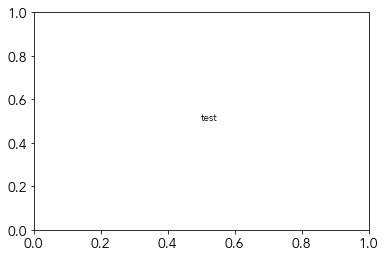

In [586]:
fig,ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
test = ax.text(0.5,0.5,"test")

In [598]:
b = test.get_window_extent()
inv = ax.transData.inverted()
inv.transform(b)

array([[0.5       , 0.48620309],
       [0.54965651, 0.53679176]])

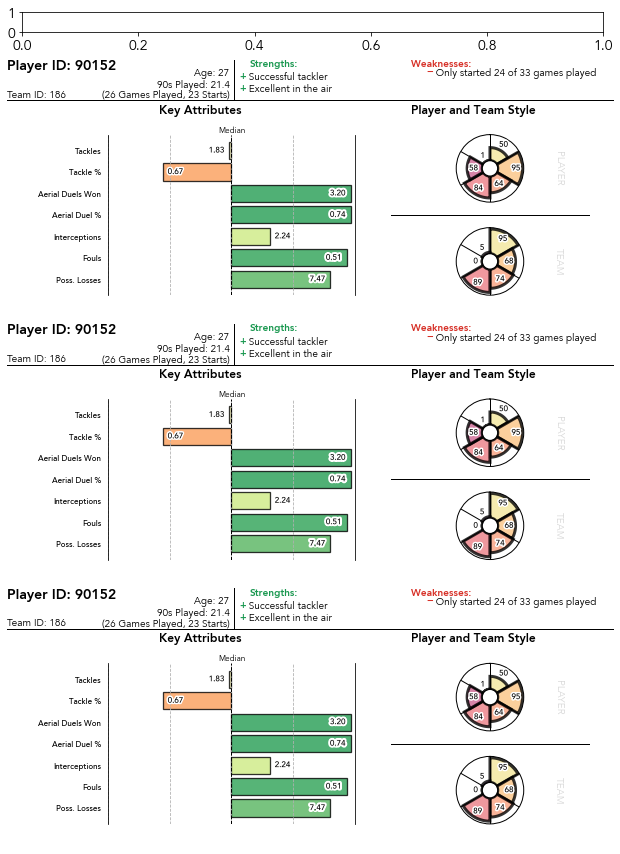

In [302]:
strength_text = "<+> Successful tackler\n<+> Excellent in the air"
weak_text = u"<\u2212> Only started 24 of 33 games played"
key_text = 'Compared to all other Centre Backs to have played at least 1800 minutes and under the age of 32.'
style_text = "Player style is compared to all Centre Backs to have played at least 900 minutes."

fig = plt.figure(figsize=(8.5,11.75),constrained_layout=True)
gs0 = fig.add_gridspec(4, 1,height_ratios=[0.2,1,1,1])#,hspace=0.5)

pid = 88580

gs = gs0[0].subgridspec(1,1)
ax_title = fig.add_subplot(gs[:])

#gs00 = []
ax_heads = []
ax1s = []
ax2s = []
ax3s = []
ax_gaps = []
ax_gaps2 = []
# Initialise all subplots first
for i in range(1,4):
    gs = gs0[i].subgridspec(5,2,width_ratios=[1,1],height_ratios=[0.6,1,0.1,1,0.2])
    #gs00.append(gs)
    ax_head = fig.add_subplot(gs[0,:])
    ax1 = fig.add_subplot(gs[1:4,0])
    ax2 = fig.add_subplot(gs[1, 1],projection='polar')
    ax_gap = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[3, 1],projection='polar')
    ax_gap2 = fig.add_subplot(gs[4,:])
    
    ax_heads.append(ax_head)
    ax1s.append(ax1)
    ax2s.append(ax2)
    ax3s.append(ax3)
    ax_gaps.append(ax_gap)
    ax_gaps2.append(ax_gap2)
    
for i in range(3):
    ax_head = ax_heads[i]
    ax1 = ax1s[i]
    ax2 = ax2s[i]
    ax3 = ax3s[i]
    ax_gap = ax_gaps[i]
    ax_gap2 = ax_gaps2[i]
    #ax_gap2.axis('off')
    player_overview_plot_gs(90152,df,df_players,df_pos_p90,df_pos_p90_per,strength_text,weak_text,key_text,style_text,ax_head=ax_head,ax_gap=ax_gap,ax1=ax1,ax2=ax2,ax3=ax3)
    ax_gap2.axis('off')
    
fig.savefig("test.pdf")
plt.show()

#### Using PCA

In [983]:
pca_attr = ['touches','final_third_entries','pen_area_entries','poss_lost_all','total_cross','total_pass','total_long_balls','total_through_ball','accurate_pass','accurate_through_ball','accurate_cross','total_att_assist','won_contest',
 'total_contest',
 'touches_in_opp_box',
 'total_scoring_att',
 'goals',
 'expected_goals',
 'ontarget_scoring_att',
 'xG/shot',
 'pass%']

In [ ]:
shot_attr = ['total_scoring_att','expected_goals','xG/shot']
pass_attr = ['total_pass','total_through_ball','total_att_assist']
drib_attr = ['won_contest','total_contest','touches_in_opp_box']
cross_attr = ['total_cross','total_long_balls']

In [1167]:
df_pca_p90,df_pca_p90_per = get_df_pos(df,pca_attr,nineties=10,exclude_pos=['Goalkeeper','Defender'])

In [1169]:
X = preprocessing.scale(df_pca_p90[pca_attr])

In [1171]:
pca = PCA(n_components=3)
pca.fit_transform(X);

In [1172]:
comp_rel = pca.components_;

In [1173]:
import seaborn as sns

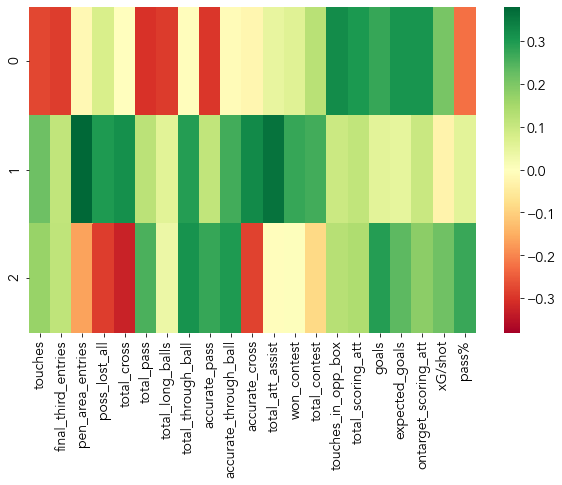

In [1174]:
fig = plt.figure(figsize=(10,6))
vlim = max(np.abs(comp_rel.min()),np.abs(comp_rel.max()))
sns.heatmap(comp_rel,vmin=-vlim,vmax=vlim,yticklabels=np.arange(0,len(comp_rel),1),xticklabels=pca_attr,cmap='RdYlGn')

### Using PCA to distinguish CB and FB

In [ ]:
'final_third_entries','total_through_ball','accurate_through_ball'

In [80]:
pca_attr = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj',
            'pen_area_entries','poss_lost_all','total_cross','total_pass',
            'total_long_balls','accurate_pass','accurate_cross',
            'total_att_assist','won_contest','total_contest','touches_in_opp_box','total_scoring_att','goals',
            'expected_goals','ontarget_scoring_att']

In [81]:
df_pca_p90,df_pca_p90_per = get_df_pos(df_adj,pca_attr,nineties=10,exclude_pos=['Goalkeeper','Midfielder','Forward'])

In [82]:
X = preprocessing.scale(df_pca_p90[pca_attr])

In [83]:
pca = PCA(n_components=2)
pca.fit_transform(X);

In [84]:
comp_rel = pca.components_;

In [85]:
import seaborn as sns

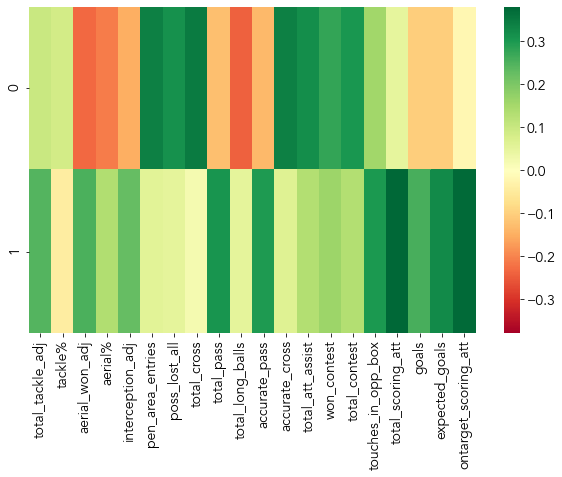

In [86]:
fig = plt.figure(figsize=(10,6))
vlim = max(np.abs(comp_rel.min()),np.abs(comp_rel.max()))
sns.heatmap(comp_rel,vmin=-vlim,vmax=vlim,yticklabels=np.arange(0,len(comp_rel),1),xticklabels=pca_attr,cmap='RdYlGn')

So it appears component 0 corresponds more to FBs, corresponding strongly to *area entries*, *crossing* and *dribbling* and not corresponding to *aerial*, *passing* and *long passing* numbers and, interestingly but I guess because of set pieces, *goals* and *shots*.

It seems CB can be distinguished by a large negative dependence on the Principal Component 0, rather than looking for FB with a large negative dependence on Principal Component 1.

In [87]:
df_fbcb_pca = pd.DataFrame(data=pca.fit_transform(X),columns=['fb','cb'],index=df_pca_p90_per.index)

In [88]:
df_fbcb_pca.loc[[18221,88580,37788,197319,17861,90152,88477,146941,32644]]

,fb,cb
player_id,,
18221,-3.804,4.898
88580,-4.023,1.313
37788,-2.533,0.412
197319,-1.974,1.102
17861,-3.925,6.013
90152,-3.180,0.742
88477,-1.435,0.638
146941,-2.868,1.230
32644,-2.610,2.813


In [89]:
df_fbcb_pca.loc[[86157,62991,86153]]

,fb,cb
player_id,,
86157,1.900,3.532
62991,2.075,4.464
86153,0.914,1.420


### Using PCA to find DM from Midfielders

In [1920]:
pca_attr = ['touches','ball_recovery','blocked_pass','total_tackle_adj','tackle%','aerial_won_adj','aerial%',
           'interception_adj','fouls','error_lead_to_goal','error_lead_to_shot','total_clearance_adj','final_third_entries','pen_area_entries',
           'poss_lost_all','total_pass','pass%','total_long_balls','long_ball_to_pass%','total_through_ball','total_att_assist',
          'won_contest','total_contest','touches_in_opp_box','total_scoring_att','expected_goals']

In [1910]:
'final_third_entries','poss_lost_all','won_contest','total_tackle_adj'

('final_third_entries', 'poss_lost_all', 'won_contest', 'total_tackle_adj')

In [1911]:
pca_attr = ['touches','ball_recovery','blocked_pass','tackle%','aerial_won_adj','aerial%',
           'interception_adj','fouls','total_clearance_adj','pen_area_entries','total_pass','total_long_balls',
            'long_ball_to_pass%','total_through_ball','total_att_assist',
          'total_contest','touches_in_opp_box','total_scoring_att','expected_goals']

In [1921]:
df_pca_p90,df_pca_p90_per = get_df_pos(df_adj,pca_attr,nineties=10,exclude_pos=['Goalkeeper','Defender','Forward'])

In [1922]:
X = preprocessing.scale(df_pca_p90[pca_attr])

In [1933]:
pca = PCA(n_components=4)
pca.fit_transform(X);

In [1934]:
comp_rel = pca.components_;

In [1935]:
import seaborn as sns

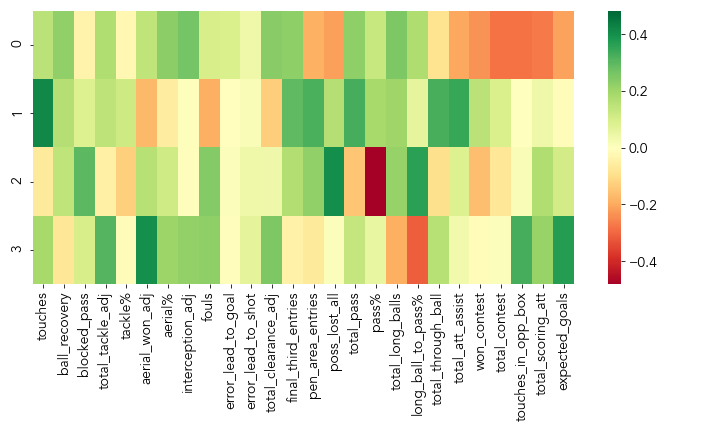

In [1936]:
fig = plt.figure(figsize=(10,6))
vlim = max(np.abs(comp_rel.min()),np.abs(comp_rel.max()))
sns.heatmap(comp_rel,vmin=-vlim,vmax=vlim,yticklabels=np.arange(0,len(comp_rel),1),xticklabels=pca_attr,cmap='RdYlGn')
plt.tight_layout()
plt.show()

In [1939]:
df_dm_pca = pd.DataFrame(data=pca.fit_transform(X),columns=[0,1,2,3],index=df_pca_p90_per.index)

In [1940]:
df_dm_pca.loc[[44989,76688,89335,192364,37055]]

,0,1,2,3
player_id,,,,
44989,2.173,4.829,-0.771,-0.869
76688,-0.597,1.261,-0.649,0.880
89335,0.968,-1.068,0.849,1.873
192364,4.464,0.601,0.169,-1.010
37055,1.772,2.287,-0.945,0.166


## Relation between Attributes

### Are *total_tackle_adj* and *total_pass* related at the team level?

In [1493]:
tackle_adj_attr = ['total_tackle_adj']
tackle_attr = ['total_tackle']
pass_attr = ['total_pass']
style_attr_cb = [pass_attr,tackle_attr,tackle_adj_attr]

In [1494]:
df_style_team = get_df_style(df_adj,style_attr_cb,styles=['pass','tackle','tackle_adj'],
             exclude_pos=['Goalkeeper','Midfielder','Forward'],team=True)

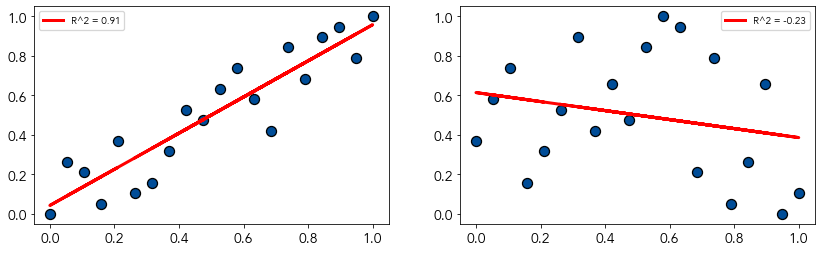

In [1496]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
x = df_style_team['pass'].to_numpy()
y = df_style_team['tackle_adj'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
axs[0].scatter(x,y)
axs[0].plot(x, intercept + slope*x, 'r', label='R^2 = {:.2f}'.format(r_value))
axs[0].legend()

y = df_style_team['tackle'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
axs[1].scatter(x,y)
axs[1].plot(x, intercept + slope*x, 'r', label='R^2 = {:.2f}'.format(r_value))
axs[1].legend()
plt.show()

Thanks to the possession adjustment *total_tackle_adj* becomes highly correlated with *total_pass*.

### Are *final_third_entries* and *long_ball_to_pass%* related in Centre Backs?

In [2126]:
cb_attr_key = ['total_tackle_adj','tackle%','aerial_won_adj','aerial%','interception_adj','final_third_entries',
               'poss_lost_all','error_lead_to_shot','fouls',
              'total_pass','total_long_balls','long_ball_to_pass%']

In [2127]:
cb_tackle_attr = ['total_tackle_adj','tackle%']
cb_aerial_attr = ['aerial_won_adj','aerial%']
cb_inter_attr = ['interception_adj']
cb_pass_attr = ['final_third_entries']

In [2128]:
df_pos_p90, df_pos_p90_per = get_df_pos(df_adj,cb_attr_key,nineties=20,age_range=(0,32),exclude_pos=['Goalkeeper','Midfielder','Forward'])
df_pos_p90 = pd.merge(df_pos_p90,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)
df_pos_p90_per = pd.merge(df_pos_p90_per,df_fbcb_pca['fb'],how='left',left_index=True,right_index=True)

In [2129]:
df_pos_p90 = df_pos_p90[df_pos_p90['fb'] <= 0].copy()
df_pos_p90_per = df_pos_p90_per[df_pos_p90_per['fb'] <= 0].copy()

In [2137]:
x = df_pos_p90_per['long_ball_to_pass%'].to_numpy()
y = df_pos_p90_per['final_third_entries'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

In [2138]:
r_value

0.5449914487113119

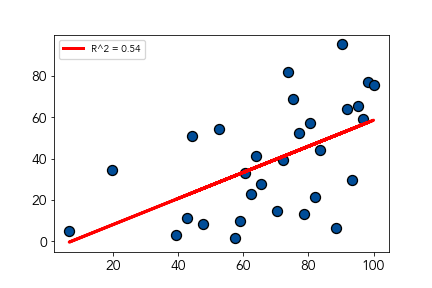

In [2139]:
plt.scatter(x,y)
plt.plot(x, intercept + slope*x, 'r', label='R^2 = {:.2f}'.format(r_value))
plt.legend()
plt.show()

So it really seems more long balls is a reasonable indicator of *final_third_entries*. Hence, I am not sure it is appropriate to directly link *final_third_entries* to progression - it could just be a result of clearances.

In [1405]:
x = df_pos_p90_per['long_ball_to_pass%'].to_numpy()
y = df_pos_p90_per['poss_lost_all'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

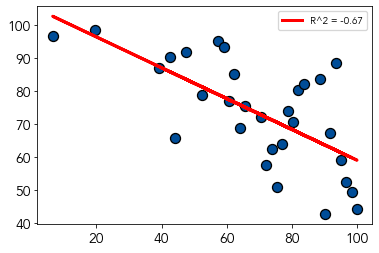

In [1407]:
plt.scatter(x,y)
plt.plot(x, intercept + slope*x, 'r', label='R^2 = {:.2f}'.format(r_value))
plt.legend()
plt.show()

We see *long_ball_to_pass%* is a decent indicator of *poss_lost_all*. Hence, when judging *poss_lost_all* keep in mind those that perform a lot of long balls tend to be worse.